# Solving a mincost k-SAT problem using QAOA

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

We want to find the $N$ (almost) optimal configurations in an attributed feature model.

The system can be described by the following boolean formula:

$
(x_1 \vee x_2) \wedge (x_2 \vee \neg x_3 \vee x_4) \wedge (x_3 \vee \neg x_5 \vee \neg x_6)
$

Furthermore, there is an implementation cost associated with each feature, as shown in the table below.

| Feature | Cost $c_i$ |
| --- | --- |
| $x_1$ | 30 |
| $x_2$ | 20 |
| $x_3$ | 25 |
| $x_4$ | 50 |
| $x_5$ | 10 |
| $x_6$ | 10 |

# Quantum Approximation Optimization Algorithm
Approximates the solution of a combinatorial optimization problem consisting of:
- $n$ binary variables
- $m$ clauses
- objective function $C(z)$

The domain of the problem is unconstrained, thus the algorithms goal is to find an (almost) optimal bistring $z=z_1...z_n$

It refines VQA and uses the Alternating Operator Ansatz.
The algorithm consists of a classical and quantum part.

On a quantum computer a circuit is constructed which is parameterized by $\gamma$ and $\beta$.
Initially the uniform superposition state $H^{\otimes n}$ is prepared.

Two operators $U(C,\gamma)$ and $U(B,\beta)$ are constructed.
The phase-separating operator $U(C,\gamma)$ encodes $C$  and applies a phase shift $e^{-i\gamma}$ on every computational basis state for every clause that is fulfilled.
The mixing operator $U(B, \beta)$ changes the amplitude of solutions using rotation $R_x$.

Both $U(C,\gamma)$  and $U(B,\beta)$ are then applied $p$ times according to the hyperparameter $p \in \mathbf{N}$.
Finally, measurements gates are added.

The circuit has a shallow circuit depth of at most $mp+m$.

On a classical computer the cost of $C(z)$ for the current evaluation is evaluated.
Either the process is terminated if the termination condition is met ($C(z)$ is sufficiently low), or the parameters $\gamma$ and $\beta$ are optimized classically.

$-2\pi\lt\gamma\lt2\pi$ and $-\pi\lt\beta\lt\pi$

## Quantum circuit
We start by defining the parameteriezed circuit.

In [1]:
# Notebook Setup
from IPython.core import page
page.page = print

from pprint import pprint

### Initialization
Uniform superposition by applying Hadamard gates $H$ on every qubit.

In [2]:
# Uniform Superposition Initialization
from qiskit import QuantumCircuit


def add_all_hadamards(qc, nqubits):
    """
        Apply an H-gate to all 'qubits' in qc
    """
    for q in nqubits:
        qc.h(q)
    return qc

def superposition_circuit(nqubits: int) -> QuantumCircuit:
    """
        Create a new quantum circuit where all qubits are initialized to |+>
    """
    qc_0 = QuantumCircuit(nqubits)
    return add_all_hadamards(qc_0, range(nqubits))

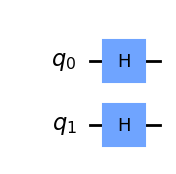

In [3]:
superposition_circuit(2).draw(output="mpl")

### Mixing operator
The mixing operator $U(B, \beta)$ applies a rotation around $X$ of $2*\beta$ on every qubit using $R_x$ gates.

In [4]:
from qiskit.circuit import Parameter


# Mixer Hamiltonian
def mixer_circuit(nqubits: int) -> tuple[QuantumCircuit, Parameter]:
    """
        Creates a mixer circuit for the given number of qubits

        :param nqubits: The number of qubits to create the circuit for
    """
    beta = Parameter("$\\beta$")
    qc_mix = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix, beta

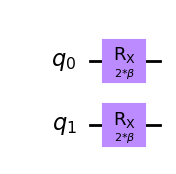

In [5]:
example_qc_mixer, _ = mixer_circuit(2)
example_qc_mixer.draw(output="mpl")

### Phase-separating operator

The phase-seperating operator $U(C, \gamma)$ encodes $C$ and can be derived from a cost Hamiltonian $H_{Ctot}$ in Ising-form.
We can describe $H_{Ctot}$ in a form where for $m$ clauses operating on one or multiple qubits the values of $C$ are encoded.
We later describe how such a Hamiltonian can be constructed for our concrete problem class.

In [6]:
# Hamiltonians may be described as a dict of tuples describing acting qubits and a value for each clause
# hamiltonian = {(q1?, q2?, ...) : factor}
sat_hamiltonian = {
    (): 1,
    (0,): 0.5,
    (1,): 0.5,
    (2,): -0.5,
    (0, 1): -0.25,
    (1, 2): 0.25,
    (2, 3): 0.25,
    (4, 5): -0.25,
    (1, 2, 3): -0.125,
    (2, 4, 5): 0.125
}

Clauses on one qubit can then be translated into $R_z$ rotations and clauses on two qubits can be translated into the symmetric $R_{zz}$ gate.
For clauses of higher degree we need to implement the corresponding $R_{z ... z}$ gate.
We do this by decomposing the $R_{z ... z}$ gate into multiple CNOT gates and a single $R_z$ gate as illustrated by [Glos et al](https://arxiv.org/pdf/2009.07309.pdf).

In [7]:
# R_{zzz} gate
from qiskit import QuantumCircuit

def k_rz_gate(qc: QuantumCircuit, qubits: list, gate_parameter: float) -> QuantumCircuit:
    """
        Applies a Z gate across the given qubits with the given parameter

        :param qc: The quantum circuit to apply the gate to
        :param qubits: The qubits to apply the gate to
        :param gate_parameter: The parameter to apply the gate with
    """
    if len(qubits) == 0:
        return qc
    for index, qubit in enumerate(qubits):
        if index < len(qubits) - 1:
            qc.cnot(qubit, qubits[index + 1])

    qc.rz(gate_parameter, qubits[-1])

    qubits.reverse()

    for index, qubit in enumerate(qubits):
        if index < len(qubits) - 1:
            qc.cnot(qubits[index + 1], qubit)

    return qc

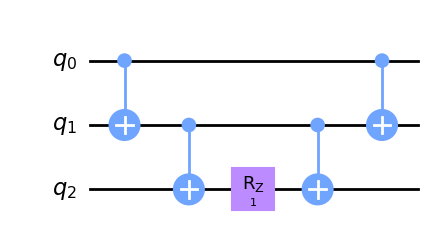

In [8]:
qubits = [0, 1, 2]
qc = QuantumCircuit(len(qubits))
qc_zzz = k_rz_gate(qc, qubits, 1)
qc_zzz.draw(output='mpl')

Using this implementation of general $R_{z ... z}$ gates, we can now implement the phase-separating operator for our example.
For the sake of simplicity we also use this implementation for clauses on one and two qubits as it is equivalent to the $R_z$ and $R_{zz}$ gates.

In [9]:
from qubovert.utils import DictArithmetic
import math


def problem_circuit(hamiltonian: DictArithmetic, nqubits: int) -> tuple[QuantumCircuit, Parameter]:
    """
        Creates a quantum circuit for the given hamiltonian

        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
    """
    gamma = Parameter("$\\gamma$")
    qc_p = QuantumCircuit(nqubits)
    normalization = math.pi/max(hamiltonian.values())

    for key, factor in hamiltonian.items():
        k_rz_gate(qc_p, list(key), 2 * normalization * factor * gamma)

    return qc_p, gamma

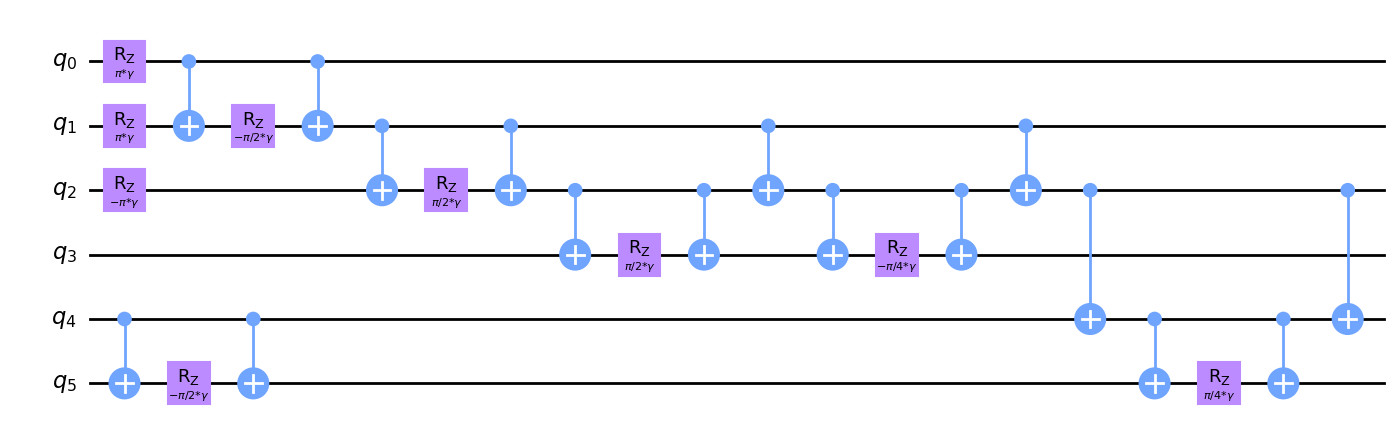

In [10]:
example_qc_problem, _ = problem_circuit(sat_hamiltonian, 6)
example_qc_problem.draw(output='mpl')

### QAOA circuit
Now we can create a QAOA circuit for a problem hamiltonian.

The circuit can also be warmstarted by initializing a specific state $\ket{s}$ instead of a uniform superposition.

In [11]:
from typing import Callable


# QAOA Circuit
def qaoa_circuit(problem_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, nlayers: int,
                 amplitude_vector: list[float] = None, measure: bool = True)\
        -> tuple[QuantumCircuit, Parameter, Parameter]:
    """
        Creates a QAOA circuit for the given hamiltonian

        :param problem_circuit: The method for creating the corresponding problem quantum circuit
        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
        :param nlayers: The number of layers to create the circuit for
        :param amplitude_vector: The amplitude vector to use for the circuit
        :param measure: Whether to measure the circuit
    """
    if amplitude_vector is not None:
        # warm start
        qc = QuantumCircuit(nqubits)
        qc.initialize(amplitude_vector)
    else:
        # equal superposition
        qc = superposition_circuit(nqubits)

    qg_mixer, beta = mixer_circuit(nqubits)
    qg_problem, gamma = problem_circuit(hamiltonian, nqubits)

    for layer in range(nlayers):
        qc.barrier()
        qc = qc.compose(qg_problem)
        qc.barrier()
        qc = qc.compose(qg_mixer)

    if measure:
        qc.measure_all()
    return qc, gamma, beta

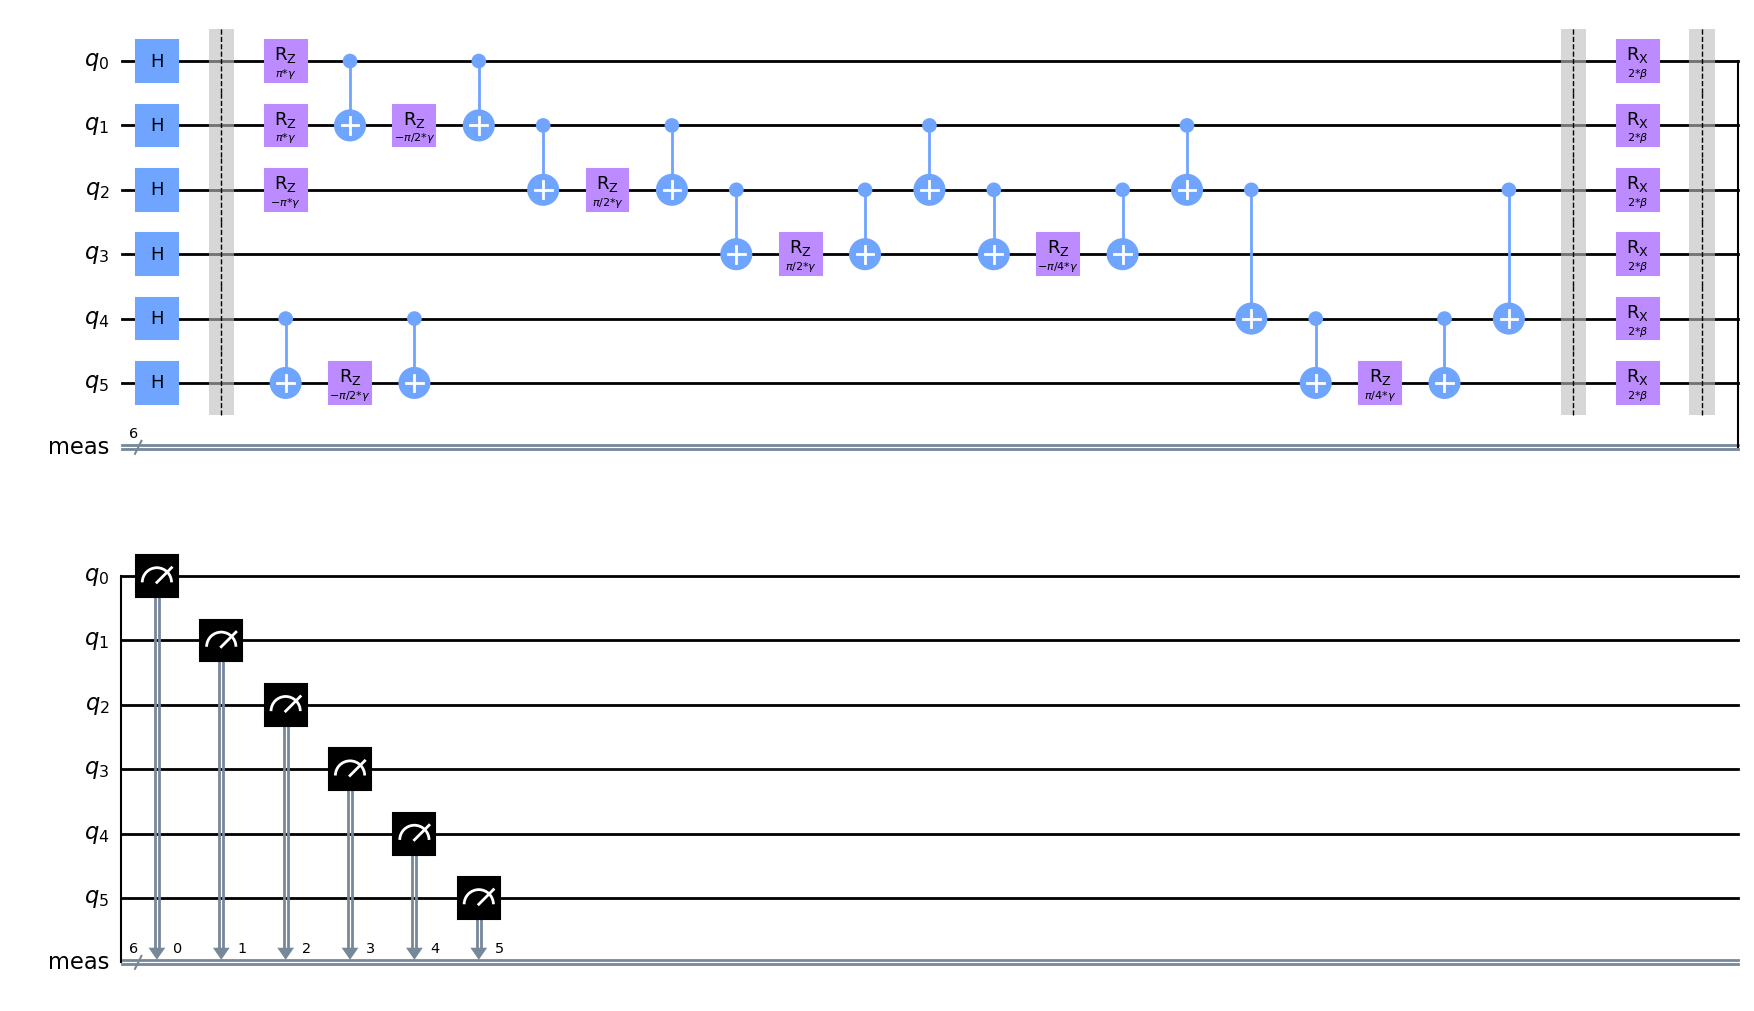

In [12]:
example_qaoa_circuit, _, _ = qaoa_circuit(problem_circuit, sat_hamiltonian, 6, 1)
example_qaoa_circuit.draw(output="mpl")

### Quantum routine
Executes QAOA circuit and returns circuit and results

In [13]:
from qiskit.result import Counts
from qiskit import transpile, Aer


def quantum(problem_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, layers: int, beta_val: float,
            gamma_val: float, shots: int = 512, amplitude_vector: list[float] = None) -> tuple[Counts, QuantumCircuit]:
    qc, beta, gamma = qaoa_circuit(problem_circuit, hamiltonian, nqubits, layers, amplitude_vector)

    # Set parameters for qc
    qc = qc.bind_parameters({
        beta: beta_val,
        gamma: gamma_val
    })

    # run and measure qc
    qasm_sim = Aer.get_backend('qasm_simulator')
    transpiled_qaoa = transpile(qc, qasm_sim)
    results = qasm_sim.run(transpiled_qaoa, shots=shots).result()
    counts = results.get_counts()

    return counts, qc

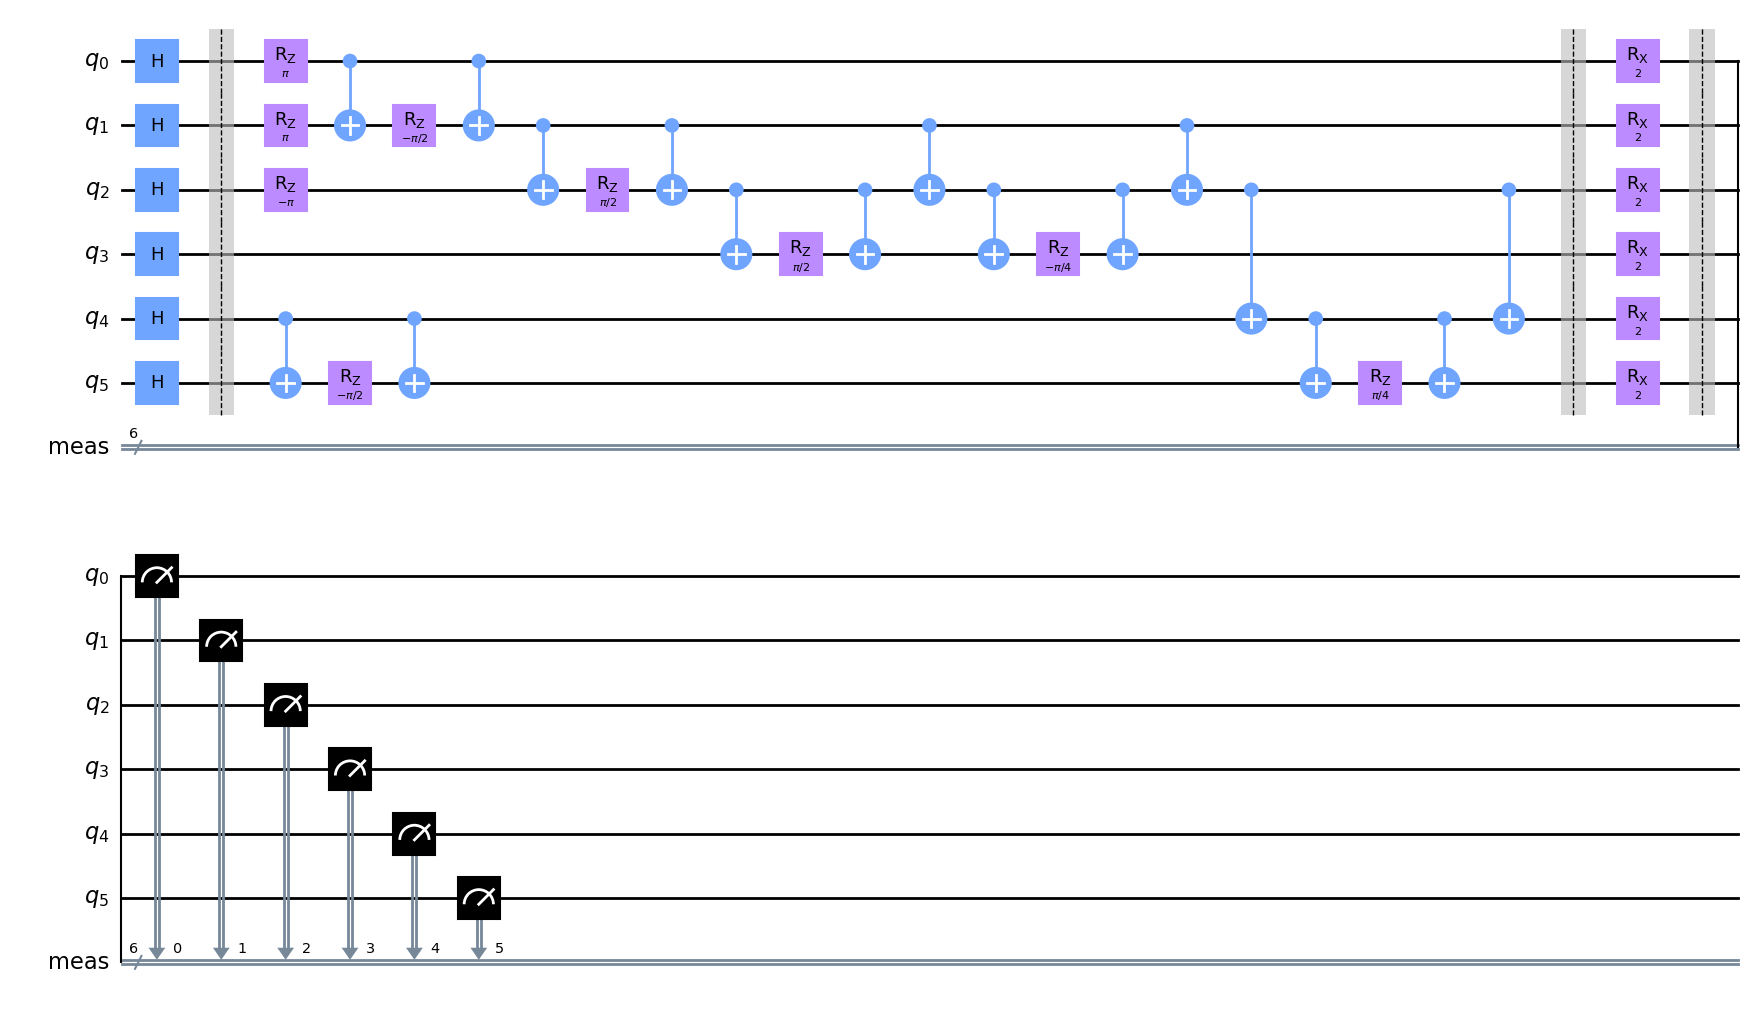

In [14]:
counts, qc = quantum(problem_circuit, sat_hamiltonian, 6, 1, 1, 1)
qc.draw(output="mpl")

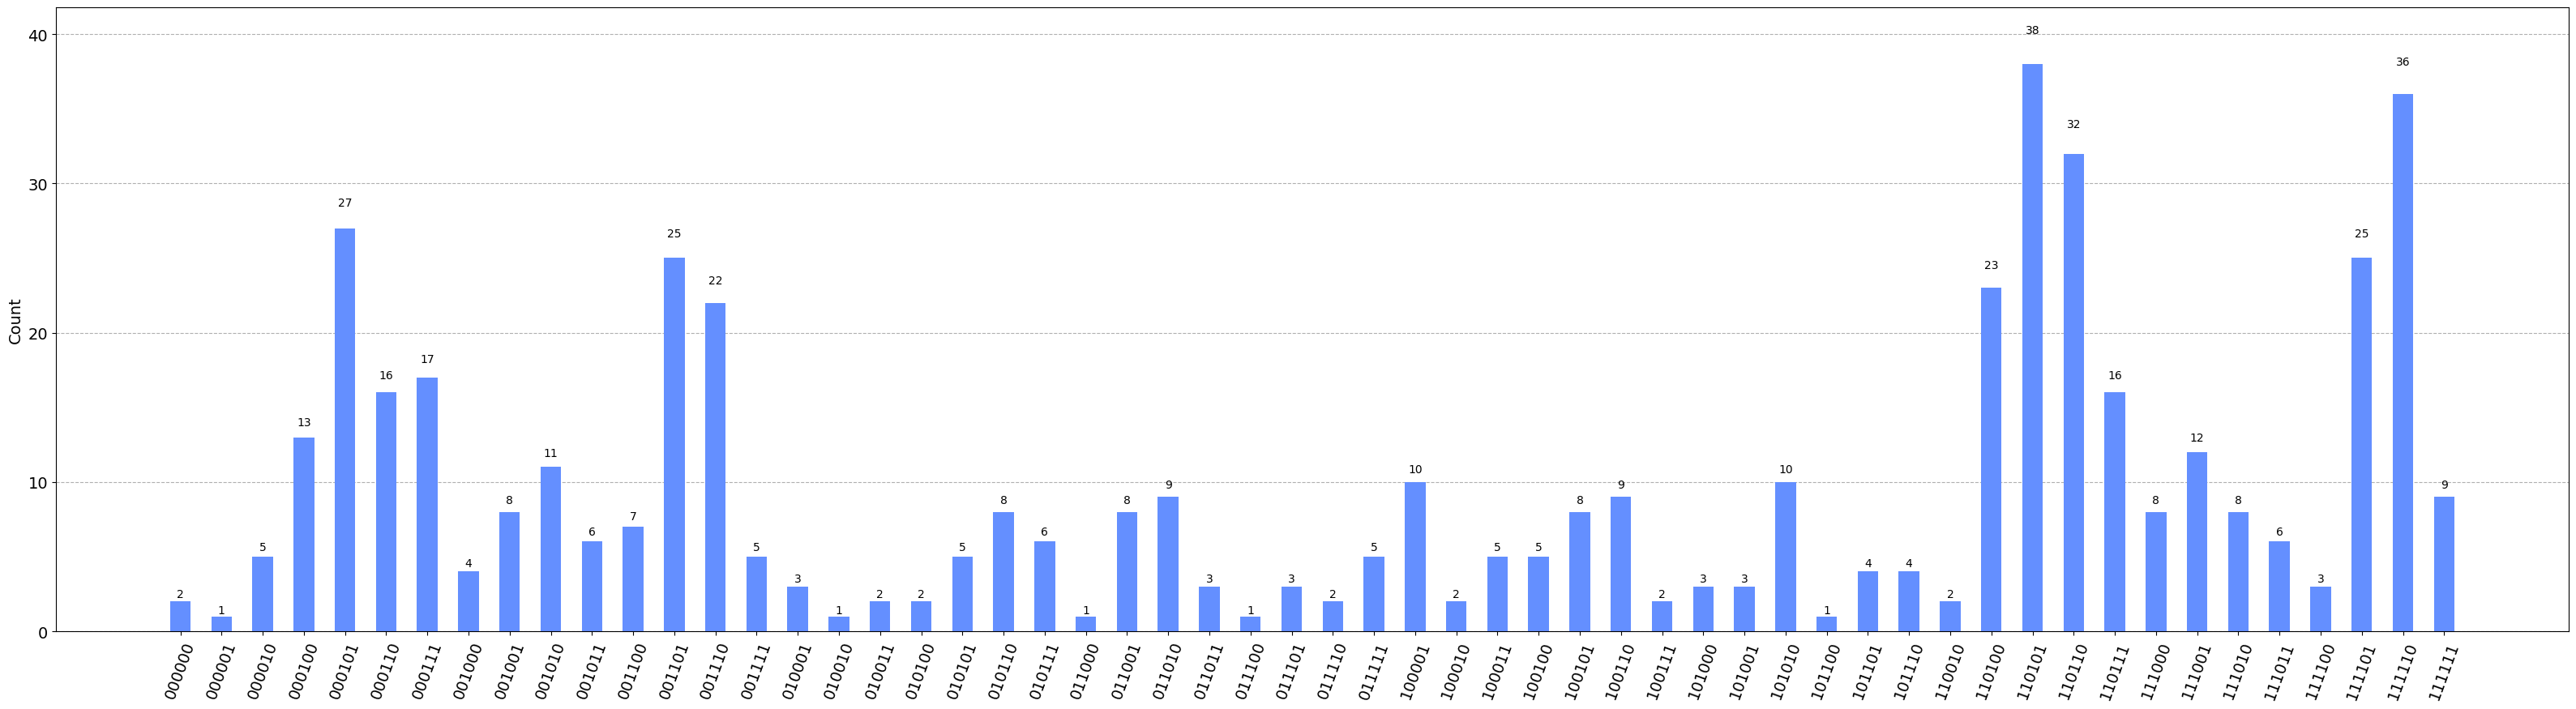

In [15]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, figsize=(40, 10))

## Creating a problem specific Hamiltonian

### Creating a cost function satisfying features

To get the penalties for general clauses $(x_i \vee \dots \vee x_j \vee \neg x_k \vee \dots \vee \neg x_l)$, we can use the following term:

$$(1 - x_i) \dots (1 - x_j) (x_k) \dots (x_l)$$

Using this method we can transform our example into the corresponding PUBO model.

$$
min~y(x) = (1 - x_1)(1 - x_2) + (1 - x_2)(x_3)(1 - x_4) + (1 - x_3)(x_5)(x_6)\\
= 1 - x_1 - x_2 + x_3 + x_1 x_2 - x_2 x_3 - x_3 x_4 + x_5 x_6 + x_2 x_3 x_4 - x_3 x_5 x_6
$$

$y(x)$ is the integer of unsatisfied clauses. In other words, $y=0$ indicates that all clauses are satisfied, which is desired for this problem.

### Creating a cost function for feature costs

For the feature costs, we can formulate a sum that adds a features cost if it is in the input vector x.
$$
k(x) = \sum_{x}^{} c_i x_i
$$


### Combining the functions
In our example, we want to find a valid configuration with the minimum cost, so we sum the two previous functions and add a penalty factor $\alpha$ to be able to change the influence of our SAT constraints.

$$
min~f(x) = k(x) + \alpha y(x)
$$

We assume $\alpha \gg 0$, the exact value probably depends on the value of $k(x)$.

### Forming Hamiltonians
We got our QUBO cost function defined. We now need to transform the Binary input space $x_i \in \{0,1\}$ to the Ising Spin model of $s_i \in \{-1, 1\}$. 

Replace $x_i$ with $S_i = 2x_i-1$ meaning $x_i = \frac{1 - S_i}{2}$ (Note that switching the sign changes the eigenvectors)

#### Cost Hamiltonian for the SAT part
Before applying it to the entire function, let's first consider only $min~y(x)$.

Ising Form:
$$
min~y(s) = 1 - \frac{1 -s_1}{2} - \frac{1 - s_2}{2} + \frac{1 - s_3}{2} + \frac{1 - s_1}{2} \frac{1 - s_2}{2} - \frac{1 - s_2}{2} \frac{1 - s_3}{2} - \frac{1 - s_3}{2} \frac{1 - s_4}{2} + \frac{1 - s_5}{2} \frac{1 - s_6}{2} + \frac{1 - s_2}{2} \frac{1 - s_3}{2} \frac{1 - s_4}{2} - \frac{1 - s_3}{2} \frac{1 - s_5}{2} \frac{1 - s_6}{2}
$$

Which expands to:

$$
min~y(s) = 1 + s_1 \frac{1}{2} + s_2 \frac{1}{2} - s_3 \frac{1}{2} - s_1 s_2 \frac{1}{4} + s_2 s_3 \frac{1}{4} + s_3 s_4 \frac{1}{4} - s_5 s_6 \frac{1}{4} - s_2 s_3 s_4 \frac{1}{8} + s_3 s_5 s_6 \frac{1}{8}\\
$$

And leaves us with a cost Hamiltonian $H_C$ with Pauli-Z-Gates $\sigma_i^z$ and an Identity $I$ on the global phase:
$$
H_C = 1 * I + \sigma_1^z \frac{1}{2} + \sigma_2^z \frac{1}{2} - \sigma_3^z \frac{1}{2} - \sigma_1^z \sigma_2^z \frac{1}{4} + \sigma_2^z \sigma_3^z \frac{1}{4} + \sigma_3^z \sigma_4^z \frac{1}{4} - \sigma_5^z \sigma_6^z \frac{1}{4} - \sigma_2^z \sigma_3^z \sigma_4^z \frac{1}{8} + \sigma_3^z \sigma_5^z \sigma_6^z \frac{1}{8}
$$

#### Cost Hamiltonian for the feature costs
We can expand the feature costs in our example according to the table above.
$$
min~k(x) = \sum_{x}^{} c_i x_i \\
= 30*x_1 + 20*x_2 + 25*x_3 + 50*x_4 + 10*x_5 + 10*x_6
$$
Which we then again transform into Ising form.

$$
min~k(s) = 15*(1-s_1) + 10*(1-s_2)+ 12.5*(1-s_3) + 25*(1-s_4) + 5*(1-s_5) + 5*(1-s_6) \\
min~k(s) = 82.5 - 15 s_1 - 10 s_2 - 12.5 s_3 - 25 s_4 - 5 s_5 - 5 s_6
$$

Which leaves us with our cost Hamiltonian $H_{Ck}$
$$
H_{Ck} = 82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 5 \sigma^z_5 - 5 \sigma^z_6
$$

#### Combining Hamiltonians

All that's left to do is choosing a suitable $\alpha$ and combining the functions.

We choose $\alpha = 200$ (sum of individual feature costs * 1.5 rounded) to make the SAT part more significant than the feature costs while still retaining enough influence to make the feature costs relevant.

$$
H_{Ctot} = H_{Ck} + \alpha ~ H_C
$$

$$
H_{Ctot} = (82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 5 \sigma^z_5 - 5 \sigma^z_6) + (200 * I + 100 \sigma_1^z + 100 \sigma_2^z - 100 \sigma_3^z - 50 \sigma_1^z \sigma_2^z + 50 \sigma_2^z \sigma_3^z + 50 \sigma_3^z \sigma_4^z - 50 \sigma_5^z \sigma_6^z - 25 \sigma_2^z \sigma_3^z \sigma_4^z + 25 \sigma_3^z \sigma_5^z \sigma_6^z)
$$

simplified to

$$
H_{Ctot} = 282.5 I + 85 \sigma_1^z + 90 \sigma_2^z - 112.5 \sigma_3^z - 25 \sigma_4^z - 5 \sigma_5^z - 5 \sigma_6^z - 50 \sigma_1^z \sigma_2^z + 50 \sigma_2^z \sigma_3^z + 50 \sigma_3^z \sigma_4^z - 50 \sigma_5^z \sigma_6^z - 25 \sigma_2^z \sigma_3^z \sigma_4^z + 25 \sigma_3^z \sigma_5^z \sigma_6^z
$$

We can implement such a Hamiltonian $H_{Ctot}$ using the `qubovert` library and solve small instances via bruteforce.

In [16]:
def solve_bruteforce(model):
    model_solution = model.solve_bruteforce()
    print("Variable assignment:", model_solution)
    print("Model value:", model.value(model_solution))
    print("Constraints satisfied?", model.is_solution_valid(model_solution))  # we don't have constraints in our model

In [17]:
from qubovert import spin_var
# define spin variables 
z1, z2, z3, z4, z5, z6 = spin_var('z1'), spin_var('z2'), spin_var('z3'), spin_var('z4'), spin_var('z5'), spin_var('z6')

# Our manually calculated hamiltonian
feetcost_model = 282.5 + 85 * z1 + 90 * z2 - 112.5 * z3 - 25 * z4 - 5 * z5 - 5 * z6 - 50 * z1 * z2 + 50 * z2 * z3 + 50 * z3 * z4 - 50 * z5 * z6 - 25 * z2 * z3 * z4 + 25 * z3 * z5 * z6
solve_bruteforce(feetcost_model)

Variable assignment: {'z1': -1, 'z2': -1, 'z3': 1, 'z4': -1, 'z5': 1, 'z6': 1}
Model value: -190.0
Constraints satisfied? True


We can also define the SAT ($H_C$) and cost ($H_{Ck}$) Hamiltonians separately and combine them afterwards.

In [18]:
# cost and sat individually
from qubovert import boolean_var

# define binary vars
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')

# SAT Penalty
alpha_sat = 200

# SAT PUBO
sat_model = 1 - x1 - x2 + x3 + x1*x2 - x2*x3 - x3*x4 + x5*x6 + x2*x3*x4 - x3*x5*x6

# Cost PUBO
cost_model = 30*x1 + 20*x2 + 25*x3 + 50*x4 + 10*x5 + 10*x6

# Combine models
combined_model = cost_model + alpha_sat * sat_model
print("PUBO Combined Model:")
pprint(combined_model)
print("Ising Combined Model: ")
combined_hamiltonian = combined_model.to_puso()
pprint(combined_hamiltonian)

PUBO Combined Model:
{(): 200,
 ('x1',): -170,
 ('x1', 'x2'): 200,
 ('x2',): -180,
 ('x2', 'x3'): -200,
 ('x2', 'x3', 'x4'): 200,
 ('x3',): 225,
 ('x3', 'x4'): -200,
 ('x3', 'x5', 'x6'): -200,
 ('x4',): 50,
 ('x5',): 10,
 ('x5', 'x6'): 200,
 ('x6',): 10}
Ising Combined Model: 
{(): 172.5,
 (0,): 35.0,
 (0, 1): 50.0,
 (1,): 65.0,
 (1, 2): -25.0,
 (1, 2, 3): -25.0,
 (1, 3): 25.0,
 (2,): -12.5,
 (2, 3): -25.0,
 (2, 4): -25.0,
 (2, 4, 5): 25.0,
 (2, 5): -25.0,
 (4,): -30.0,
 (4, 5): 25.0,
 (5,): -30.0}


## Classical Routine
On the classical side we now need functions to evaluate $C$, which correspond to computing the energy of the Hamiltonian for a specific measured output (a configuration in our case) by `compute_config_energy`.

In [19]:
def compute_config_energy(hamiltonian: DictArithmetic, config: list[int]) -> float:
    """
        Computes the energy of a given configuration (ising input) for a given hamiltonian (ising form)

        :param hamiltonian: The hamiltonian to compute the energy for
        :param config: The configuration to compute the energy for
    """
    energy = 0
    for key, factor in hamiltonian.items():
        term_energy = factor
        for qubit in key:
            term_energy *= config[qubit]
        energy += term_energy
    return energy

As the circuit is executed multiple times the function `compute_hamiltonian_energy` can be used with different strategies.
Currently, we provide average, top and minimum strategies and the best ones to use are minimum or average.

In [20]:
def compute_hamiltonian_energy(hamiltonian, counts, strategy='avg'):
    """
        Compute the energy state of a hamiltonian from measurements.
        
        :param hamiltonian: the hamiltonian (QUSO/PUSO) describing the system
        :param counts: measurement results for a quantum system for the hamiltonian
        :param strategy: method for actually evaluating the hamiltonian. Available: 'avg', 'top', 'min'
    """
    if strategy == 'avg':
        return hamiltonian_strategy_average(hamiltonian, counts)
    elif strategy == 'top':
        return hamiltonian_strategy_top(hamiltonian, counts)
    elif strategy == 'min':
        return hamiltonian_strategy_min(hamiltonian, counts)
    else:
        raise RuntimeError(f"Unsupported strategy: {strategy}")
    
    
def hamiltonian_strategy_min(hamiltonian, counts):
    """
        Finds the _measured_ configuration with the least energy and returns its value.
    """
    min_energy = float('inf')
    for config_str in counts.keys():
        # convert the 0/1 feature string to ising integers
        config = [-1 if s == "0" else 1 for s in config_str]
        energy = compute_config_energy(hamiltonian, config)
        min_energy = energy if energy < min_energy else min_energy
    return min_energy


def hamiltonian_strategy_average(hamiltonian, counts):
    """
        Computes the average energy across the entire measurement for the given hamiltonian
    """
    average_energy = 0
    for config_str in counts.keys():
        # convert the 0/1 feature string to ising integers
        config = [-1 if s == "0" else 1 for s in config_str]
        energy = compute_config_energy(hamiltonian, config)*counts.get(config_str)
        average_energy += energy
    average_energy /= counts.shots()
    return average_energy


def hamiltonian_strategy_top(hamiltonian, counts):
    """
        Computes the energy of the configuration that was measured the most for the given hamiltonian
    """
    # take the config that was measured most often
    config_str = max(counts, key=counts.get) 
    # convert the 0/1 feature string to ising integers
    config = [-1 if s == "0" else 1 for s in config_str]
    return compute_config_energy(hamiltonian, config)

We can then define a function that given a beta and gamma as input creates a quantum circuit, executes it multiple times and returns the energy.

This function can be used in a classical optimizer.

In [21]:
def get_expectation(problem_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, nlayers: int,
                    shots: int = 128, amplitude_vector: list[float] = None, strategy: str = 'avg') -> Callable:
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc, beta, gamma = qaoa_circuit(problem_circuit, hamiltonian, nqubits, nlayers, amplitude_vector)

        # Set parameters for qc
        qc = qc.bind_parameters({
            beta: theta[0],
            gamma: theta[1]
        })

        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_hamiltonian_energy(hamiltonian, counts, strategy=strategy)

    return execute_circ

## QAOA cost landscape
To get a better understanding of the QAOA cost landscape, we can plot the cost for different values of $\gamma$ and $\beta$.

In [22]:
from qiskit_aer import StatevectorSimulator
from matplotlib import pyplot as plt
import sys
import numpy as np


def plot_beta_gamma_cost_landscape(problem_circuit: Callable, hamiltonians: list[dict], strategies: list[str],
                                   nqubits: int, step_size: float):
    """
        Plots the cost landscape for different values of beta and gamma
        for a given list of hamiltonians and list of strategies.

        :param problem_circuit: The function for creating the corresponding problem quantum circuit
        :param hamiltonians: list of hamiltonians to plot
        :param strategies: list of strategies to plot
        :param nqubits: number of qubits
        :param step_size: step size for beta and gamma, value will be doubled for gamma as it's limits are also doubled
    """
    plot_arguments = []
    for hamiltonian in hamiltonians:
        for strategy in strategies:
            plot_arguments.append({"hamiltonian": hamiltonian, "strategy": strategy})

    x_axis = np.arange(-math.pi, math.pi, step_size)
    y_axis = np.arange(-2 * math.pi, 2 * math.pi, 2 * step_size)

    fig, axes = plt.subplots(len(hamiltonians), len(strategies), figsize=(18, 16))
    fig.suptitle(r"cost landscape for different values of $\gamma$ and $\beta$", fontsize=20)
    fig.tight_layout(pad=5.0)
    cmap = "viridis"

    for ax, arguments in zip(axes.ravel(), plot_arguments):
        ax.set_title(f"Hamiltonian: {arguments['hamiltonian']['name']}\n strategy: {arguments['strategy']}")
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel(r"$\gamma$")

        hamiltonian = arguments["hamiltonian"]["hamiltonian"]
        strategy = arguments["strategy"]

        expectation = np.zeros(shape=(len(x_axis), len(y_axis)))
        expectation_max = -sys.maxsize - 1
        expectation_min = sys.maxsize

        for i_index, i in enumerate(x_axis):
            for j_index, j in enumerate(y_axis):
                expectation_function = get_expectation_statevector(problem_circuit, hamiltonian, nqubits, 1,
                                                                   strategy=strategy)
                value = expectation_function([j, i])
                expectation[i_index][j_index] = value
    
                if expectation_max < value:
                    expectation_max = value
                elif expectation_min > value:
                    expectation_min = value

        pcm = ax.pcolormesh(x_axis, y_axis, expectation, shading="gouraud", cmap=cmap, vmin=expectation_min,
                            vmax=expectation_max)
        plt.colorbar(pcm, ax=ax)

    plt.show()
    
    
def get_expectation_statevector(problem_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, nlayers: int,
                                amplitude_vector: list[float] = None, strategy: str = 'avg') -> Callable:
    backend = StatevectorSimulator()

    def execute_circ(theta):
        qc, beta, gamma = qaoa_circuit(problem_circuit, hamiltonian, nqubits, nlayers, amplitude_vector, measure=False)

        # Set parameters for qc
        qc = qc.bind_parameters({
            beta: theta[0],
            gamma: theta[1]
        })

        statevector = backend.run(qc).result().get_statevector()

        return compute_hamiltonian_energy_from_statevector(hamiltonian, statevector, nqubits, strategy=strategy)

    return execute_circ


def hamiltonian_strategy_average_from_statevector(hamiltonian, statevector, nqubits):
    """
        Computes the average energy across all possible measurements for the given hamiltonian
    """
    probabilities = statevector.probabilities()
    average_energy = 0
    for i, probability in enumerate(probabilities):
        # convert index to ising integers
        config = [-1 if s == "0" else 1 for s in np.binary_repr(i, width=nqubits)]
        energy = compute_config_energy(hamiltonian, config)*probability
        average_energy += energy
    return average_energy


def hamiltonian_strategy_top_from_statevector(hamiltonian, statevector, nqubits):
    """
        Computes the energy of the configuration that has the highest probability for the given hamiltonian
    """
    probabilities = statevector.probabilities()
    # take the config that was measured most often
    config_index = min(range(len(probabilities)), key=probabilities.__getitem__)
    # convert index to ising integers
    config = [-1 if s == "0" else 1 for s in np.binary_repr(config_index, width=nqubits)]
    return compute_config_energy(hamiltonian, config)


def hamiltonian_strategy_min_from_statevector(hamiltonian, statevector, nqubits, threshold=0.001):
    """
        Finds the configuration with a probability above a threshold with the least energy and returns its value.
    """
    min_energy = float('inf')
    probabilities = statevector.probabilities()
    for i, probability in enumerate(probabilities):
        if probability > threshold:
            # convert index to ising integers
            config = [-1 if s == "0" else 1 for s in np.binary_repr(i, width=nqubits)]
            energy = compute_config_energy(hamiltonian, config)
            min_energy = energy if energy < min_energy else min_energy
    return min_energy


def compute_hamiltonian_energy_from_statevector(hamiltonian, statevector, nqubits, strategy='avg'):
    """
        Compute the energy state of a hamiltonian from the statevector.

        :param hamiltonian: the hamiltonian (QUSO/PUSO) describing the system
        :param statevector: the statevector for a quantum system for the hamiltonian
        :param nqubits: number of qubits in the quantum system
        :param strategy: method for actually evaluating the hamiltonian. Available: 'avg', 'top', 'min'
    """
    if strategy == 'avg':
        return hamiltonian_strategy_average_from_statevector(hamiltonian, statevector, nqubits)
    elif strategy == 'top':
        return hamiltonian_strategy_top_from_statevector(hamiltonian, statevector, nqubits)
    elif strategy == 'min':
        return hamiltonian_strategy_min_from_statevector(hamiltonian, statevector, nqubits)
    else:
        raise RuntimeError(f"Unsupported strategy: {strategy}")

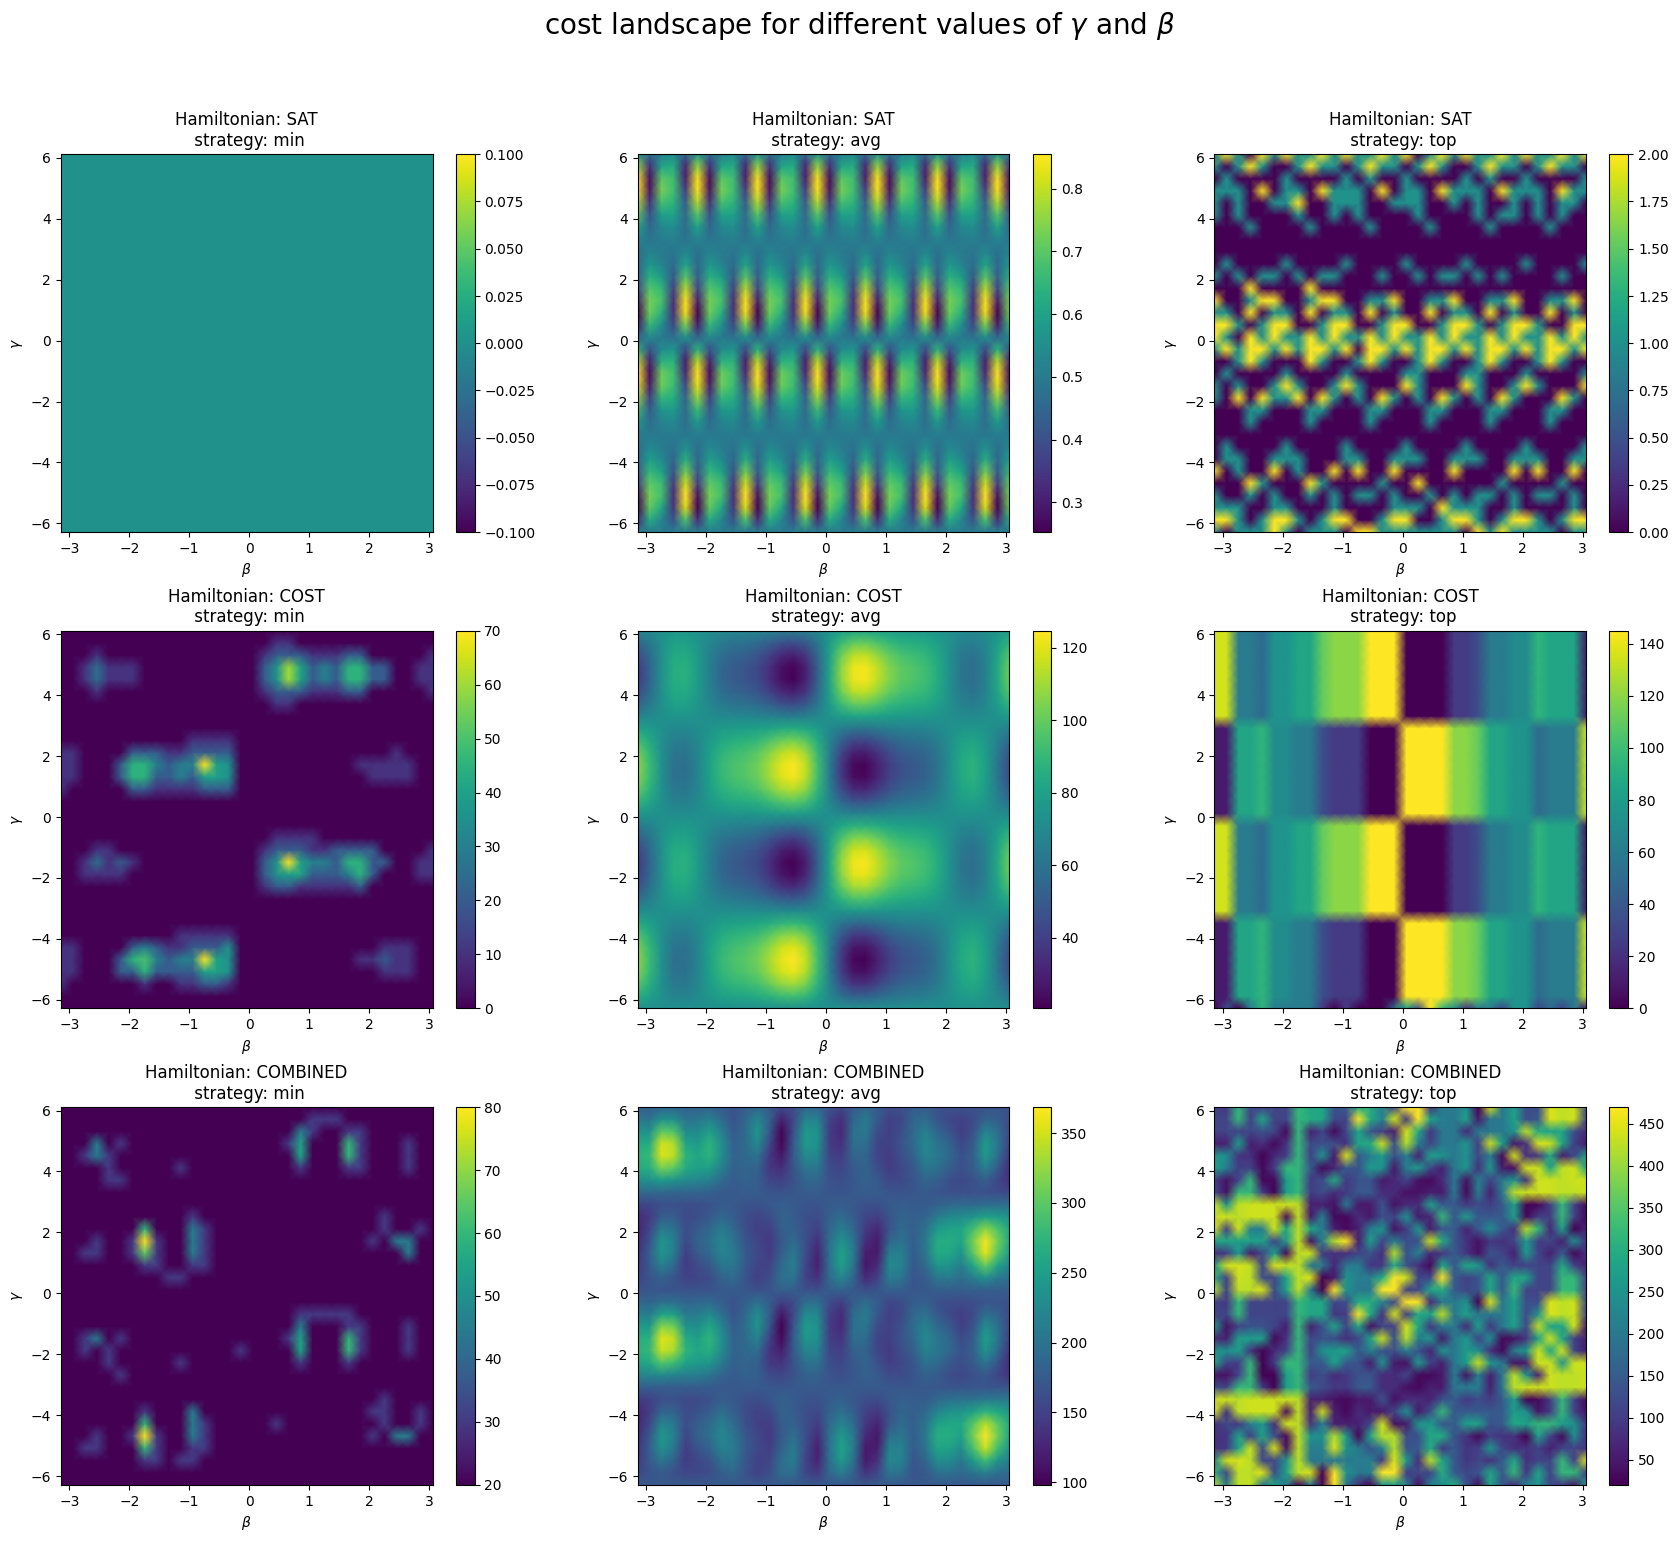

In [23]:
# Plot cost landscape for different values of beta and gamma
hamiltonians = [{'hamiltonian': sat_model.to_puso(), 'name': 'SAT'},
               {'hamiltonian': cost_model.to_puso(), 'name': 'COST'},
               {'hamiltonian': combined_hamiltonian, 'name': 'COMBINED'}]
strategies = ['min', 'avg', 'top']
plot_beta_gamma_cost_landscape(problem_circuit, hamiltonians, strategies, 6, 0.2)

## Applying QAOA
Finally, we can run the whole algorithm for a specific problem Hamiltonian.

In [24]:
from scipy.optimize import minimize


def apply_qaoa(problem_circuit: Callable, hamiltonian: DictArithmetic, layers: int = 60, n_features: int = 6,
               shots: int = 256, theta={"beta": 0.01, "gamma": -0.01}, warmstart_statevector: list[float] = None,
               strategy: str = 'avg', use_optimizer: bool = True, print_res: bool = True)\
        -> tuple[Counts, QuantumCircuit]:
    """
        Applies the QAOA Algorithm for the given problem hamiltonian in QUSO/PUSO form.

        :param problem_circuit: The function for creating the corresponding problem quantum circuit
        :param hamiltonian: the hamiltonian used for creating the quantum circuit
                            and determining the expected config cost
        :param layers: the hyperparameter p of QAOA defining how many cost-mixer-layers will be in the circuit
        :param n_features: the number of independent variables in the input hamiltonian
        :param shots: the number of shots used in a simulator run of the QAOA quantum circuit
        :param theta: dictionary with keys "beta" and "gamma" that parameterize the QAOA circuit,
                      used as start value when optimizing
        :param warmstart_statevector: statevector to warmstart to, instead of creating an equal superposition
        :param strategy: the strategy used to compute the expected config cost
        :param use_optimizer: indicates whether to optimize theta using classical optimizers
        :param print_res: indicates whether the results of the optimization should be printed
    """
    # define expectation function for optimizers
    expectation = get_expectation(problem_circuit, hamiltonian, n_features, layers, shots, warmstart_statevector,
                                  strategy=strategy)

    # optimize beta and gamma
    if use_optimizer:
        theta = optimize_parameters(theta, expectation, print_res)

        # run qaoa circuit with parameters in theta
    counts, qc = quantum(problem_circuit, hamiltonian, n_features, layers, theta["beta"], theta["gamma"], shots,
                         warmstart_statevector)
    return counts, qc


def optimize_parameters(theta: dict, expectation: Callable, print_res: bool) -> dict:
    """
        Optimizes the parameters beta and gamma of the QAOA circuit using classical optimizers.

        :param theta: dictionary with keys "beta" and "gamma" that parameterize the QAOA circuit,
                      used as start value when optimizing
        :param expectation: the expectation function used to determine the expected config cost
        :param print_res: indicates whether the results of the optimization should be printed
    """
    res = minimize(expectation, [theta["beta"], theta["gamma"]], method='COBYLA',
                   options={'maxiter': 1000, 'disp': False}, tol=1e-12)
    if print_res:
        print(res)
    return {"beta": res.x[0], "gamma": res.x[1]}

In [ ]:
hamiltonian = combined_hamiltonian
layers = 60 # more layers = higher approximation rate but more quantum errors when running on real qpu
n_features = 6
shots = 256
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
strategy = 'min'
use_warmstart = False
use_optimizer = True

if not use_warmstart:
    warmstart_statevector = None

counts, qc = apply_qaoa(problem_circuit, hamiltonian, layers, n_features, shots, theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer)

In [26]:
# Pretty Print the results of the previous cell
import matplotlib.patches as mpatches


def plot_counts_histogram(counts: Counts, nqubits: int, best_config: str, valid_configs: list[str]):
    """
        Plots a histogram of the counts for each possible config.
        The best config is highlighted in red and valid configs are highlighted in brown.

        :param counts: dictionary containing the counts for each config that was measured
        :param nqubits: number of qubits
        :param best_config: valid config with the lowest energy
        :param valid_configs: list of valid configs
    """
    for i in range(0, 2 ** nqubits):
        if not counts.keys().__contains__(np.binary_repr(i, nqubits)):
            counts[np.binary_repr(i, nqubits)] = 0

    # Sort histogram
    sorted_keys = sorted(counts.keys())
    sorted_items = sorted(counts.items(), key=lambda item: item[0])
    sorted_values = [item[1] for item in sorted_items]

    col = []
    for key in sorted_keys:
        if key == best_config:
            col.append('r')
        elif valid_configs.__contains__(key):
            col.append("brown")
        else:
            col.append('b')

    plt.rcParams["figure.figsize"] = (40, 10)
    plt.ylabel("Count")
    plt.xticks(rotation=70, ha="right")
    plt.bar(sorted_keys, sorted_values, width=0.5, color=col)

    max_count = 0
    for val in sorted_values:
        if val > max_count:
            max_count = val

    for i, val in enumerate(sorted_values):
        plt.text(x=i, y=val + max_count / 100, s=f"{val}", fontdict=dict(fontsize=10), horizontalalignment="center")

    if sorted_keys.__contains__(best_config):
        plt.axhline(y=counts[best_config], color='r', linestyle='--')

    red_patch = mpatches.Patch(color='r', label="best config")
    brown_patch = mpatches.Patch(color="brown", label="valid config")
    blue_patch = mpatches.Patch(color='b', label="invalid config")
    plt.legend(handles=[red_patch, brown_patch, blue_patch], loc="upper right")

    plt.show()

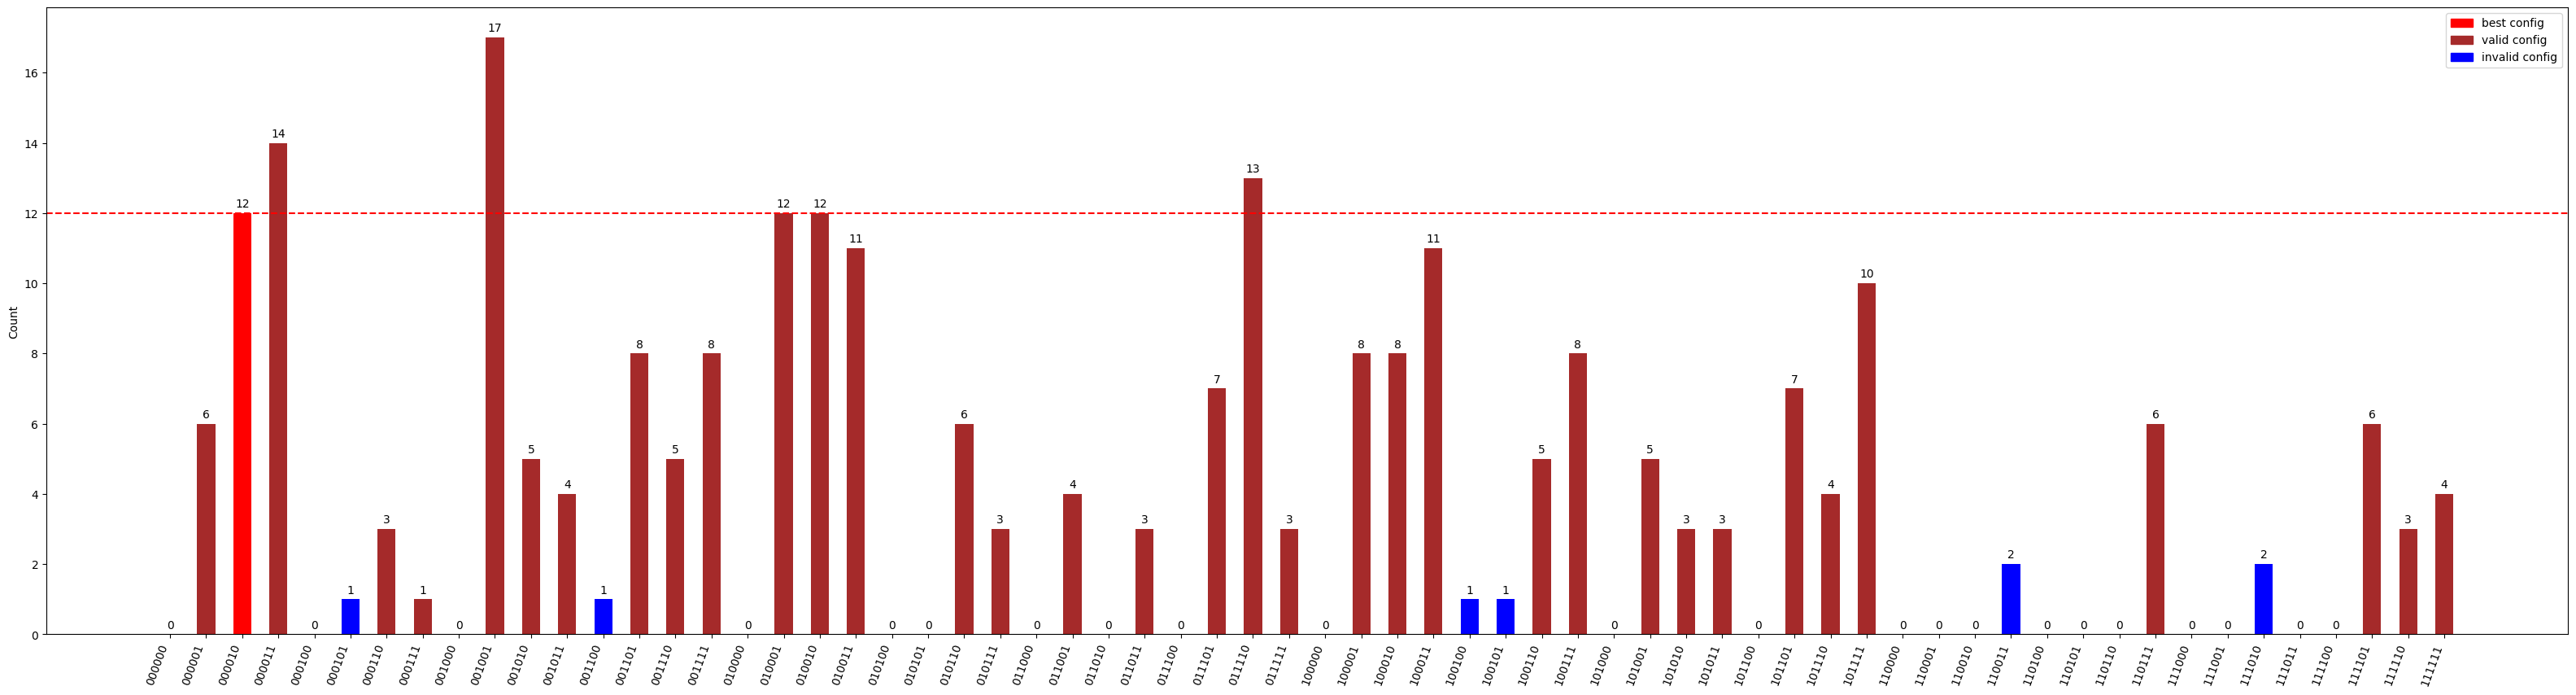

In [27]:
best_config = "000010" # 654321
valid_configs = ["111111", "011111", "101111", "001111", "110111", "010111", "100111", "000111", "011011", "101011", "001011", "010011", "100011", "000011", "111101", "011101", "101101", "001101", "011001", "101001", "001001", "010001", "100001", "000001", "111110", "011110", "101110", "001110", "110110", "010110", "100110", "000110", "011010", "101010", "001010", "010010", "100010", "000010"]

plot_counts_histogram(counts, n_features, best_config, valid_configs)

To get a better view of the probability distribution, we can apply QAOA using the statevector simulator instead of the qasm simulator.

In [28]:
# Visualize results using the StatevectorSimulator
def quantum_statevector(problem_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, layers: int,
                        beta_val: float, gamma_val: float, amplitude_vector: list[float] = None)\
        -> tuple[list[float], QuantumCircuit]:
    qc, beta, gamma = qaoa_circuit(problem_circuit, hamiltonian, nqubits, layers, amplitude_vector, measure=False)

    # Set parameters for qc
    qc = qc.bind_parameters({
        beta: beta_val,
        gamma: gamma_val
    })

    # run and measure qc
    statevector_sim = StatevectorSimulator()
    transpiled_qaoa = transpile(qc, statevector_sim)
    result = statevector_sim.run(transpiled_qaoa).result()
    probabilities = result.get_statevector().probabilities()

    return probabilities, qc


def apply_qaoa_statevector(problem_circuit: Callable, hamiltonian: DictArithmetic, layers: int = 60,
                           n_features: int = 6, theta={"beta": 0.01, "gamma": -0.01},
                           warmstart_statevector: list[float] = None, strategy: str = 'avg', use_optimizer: bool = True,
                           print_res: bool = True) -> tuple[list[float], QuantumCircuit]:
    """
        Applies the QAOA Algorithm for the given hamiltonian in QUSO/PUSO form.

        :param problem_circuit: The function for creating the corresponding problem quantum circuit
        :param hamiltonian: the hamiltonian used for creating the quantum circuit
                            and determining the expected config cost
        :param layers: the hyperparameter p of QAOA defining how many cost-mixer-layers will be in the circuit
        :param n_features: the number of independent variables in the input hamiltonian
        :param theta: dictionary with keys "beta" and "gamma" that parameterize the QAOA circuit,
                      used as start value when optimizing
        :param warmstart_statevector: statevector to warmstart to, instead of creating an equal superposition
        :param strategy: the strategy used to compute the expected config cost
        :param use_optimizer: indicates whether to optimize theta using classical optimizers
        :param print_res: indicates whether the results of the optimization should be printed
    """
    # define expectation function for optimizers
    expectation = get_expectation_statevector(problem_circuit, hamiltonian, n_features, layers, warmstart_statevector,
                                              strategy=strategy)

    # optimize beta and gamma
    if use_optimizer:
        theta = optimize_parameters(theta, expectation, print_res)

    probabilities, qc = quantum_statevector(problem_circuit, hamiltonian, n_features, layers, theta["beta"],
                                            theta["gamma"], warmstart_statevector)
    return probabilities, qc

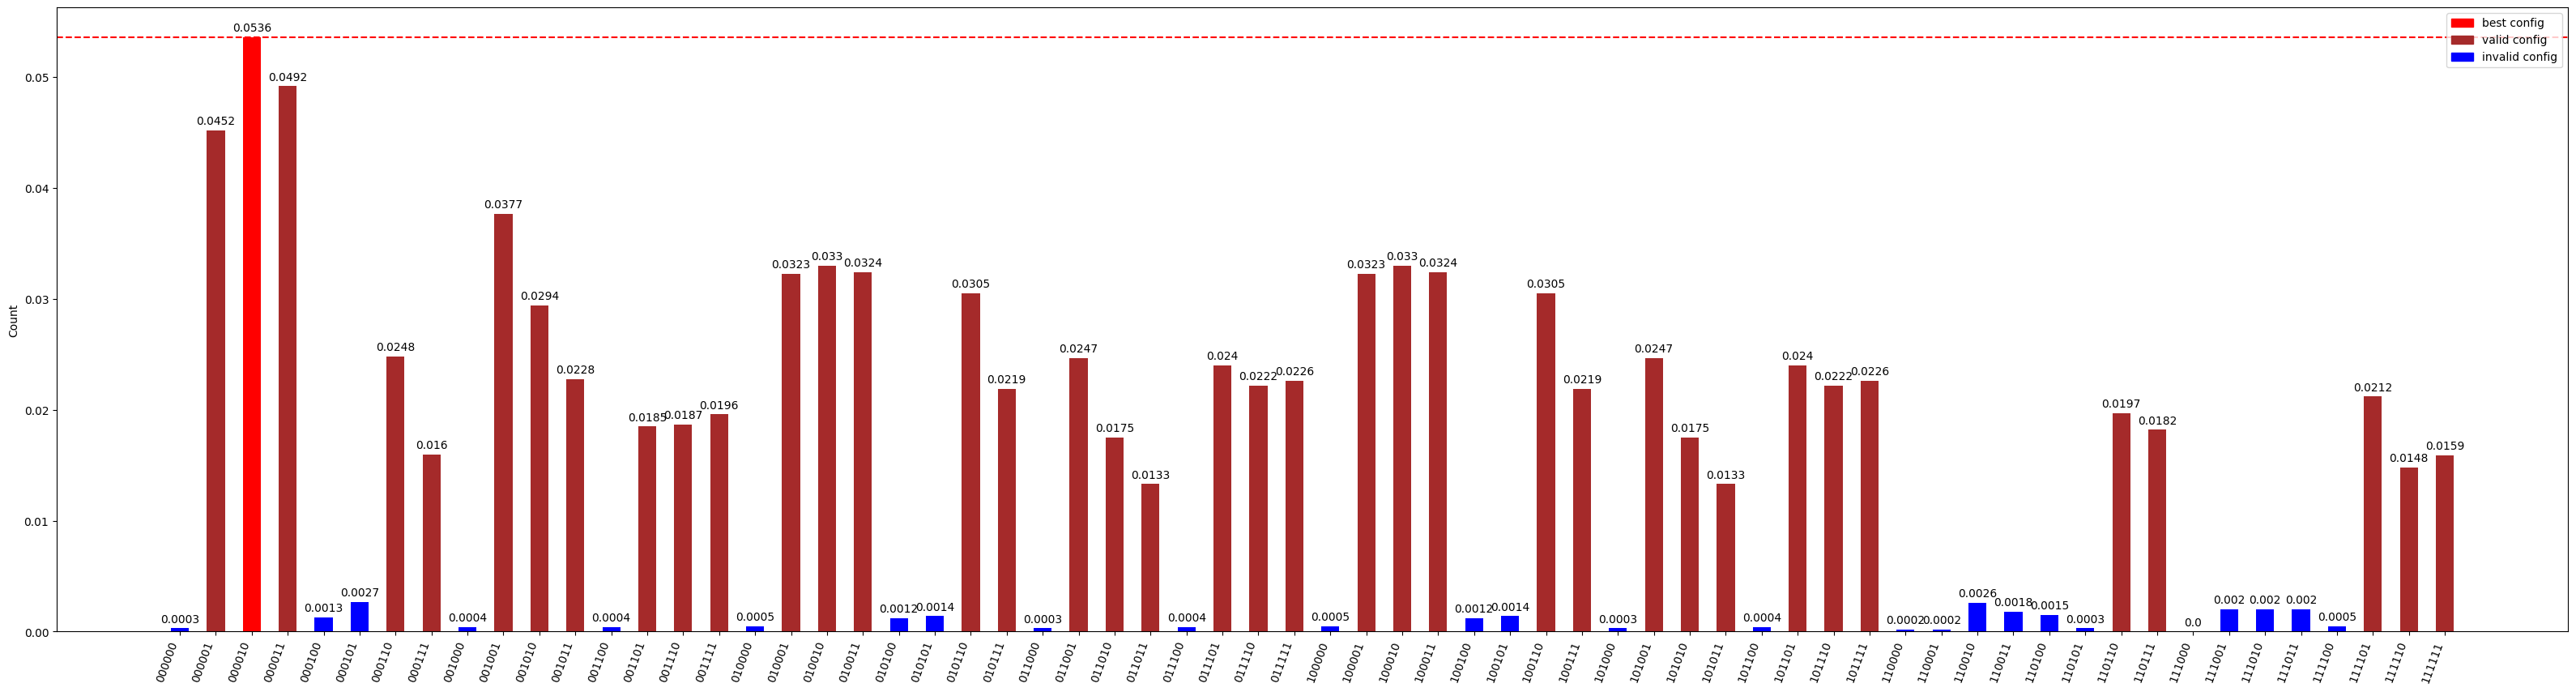

In [29]:
probabilities, _ = apply_qaoa_statevector(problem_circuit, hamiltonian, layers, n_features, theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=False)
probabilities_dict = {}
for i in range(0, 2 ** n_features):
    probabilities_dict[(np.binary_repr(i, width=6))] = round(probabilities[i], 4)

plot_counts_histogram(probabilities_dict, n_features, best_config, valid_configs)

## Quadratization of PUBOs

Instead of using the PUBO model directly, we can also quadratize the model and use the corresponding QUBO model.
For example, if we transform the clause $(x_i \vee x_j \vee x_k)$, we get the following penalty:

$$1 - x_i - x_j - x_k + x_i x_j + x_i x_k + x_j x_k - x_i x_j x_k$$

By introducing a new auxiliary variable $w_{ij} = x_i x_j$ we can rewrite this penalty as:

$$1 - x_i - x_j - x_k + w_{ij} + x_i x_k + x_j x_k - w_{ij} x_k$$

This term no longer contains a product of three variables but products of at most two variables and can therefore be used in a QUBO model.
The method for reduction by substitution above was first described by I. G. Rosenberg in "Reduction of Bivalent Maximization to the Quadratic Case" (1975) and can be found in a collection of different quadratization methods by [Dattani](https://arxiv.org/pdf/1901.04405.pdf).

We use the `to_quso()` function from the `qubovert` library to quadratize the PUBO model.
After applying QAOA to the resulting QUBO model, we can use the `convert_ancilla_bit_results()` function to convert the results back to the original PUBO model.

In [30]:
from typing import Any


def qubo_problem_circuit(hamiltonian: DictArithmetic, nqubits: int) -> tuple[QuantumCircuit, Parameter]:
    """
        Creates a quantum circuit for the given hamiltonian

        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
    """
    gamma = Parameter("$\\gamma$")
    qc_p = QuantumCircuit(nqubits)
    normalization = math.pi/max(hamiltonian.values())
    
    for key, factor in hamiltonian.items():
        acting_qubits = len(key)
        
        if acting_qubits == 0:
            pass  # identity case
        elif acting_qubits == 1:
            # single qubit term
            q1 = key[0]
            qc_p.rz(2 * normalization * factor * gamma, q1)
        elif acting_qubits == 2:
            # quadratic qubit term
            q1 = key[0]
            q2 = key[1]
            qc_p.rzz(2 * normalization * factor * gamma, q1, q2)
        else:
            # non quadratic, error
            RuntimeError(f"Non quadratic term in hamiltonian: {key, factor}")
            
    return qc_p, gamma


def get_hamiltonian_dimension(hamiltonian):
    """
        Returns the dimension of the hamiltonian (number of qubits)
    """
    nqubits = 0
    for key in hamiltonian.keys():
        for qubit in key:
            nqubits = qubit if qubit > nqubits else nqubits
    return nqubits + 1


def convert_ancilla_bit_results(results: dict[str, Any], nfeatures: int) -> dict[str, Any]:
    """
        Converts the results from the quantum computer to the results for the original problem

        :param results: The results from the quantum computer
        :param nfeatures: The number of features used in the problem
    """
    new_results = {}
    for key, value in results.items():
        new_key = key[-nfeatures:]
        if new_key in new_results:
            new_results[new_key] += value
        else:
            new_results[new_key] = value
    return new_results

Quadratized Hamiltonian:
{(): 474.0,
 (0,): 35.0,
 (0, 1): 50.0,
 (1,): 140.25,
 (1, 2): 0.25,
 (1, 6): -100.5,
 (2,): 87.75,
 (2, 3): -50.0,
 (2, 6): -100.5,
 (2, 7): -50.0,
 (3,): -25.0,
 (3, 6): 50.0,
 (4,): -4.75,
 (4, 5): 100.25,
 (4, 7): -100.5,
 (5,): -4.75,
 (5, 7): -100.5,
 (6,): -150.5,
 (7,): -50.5}
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 20.0
       x: [ 1.000e-02 -1.000e-02]
    nfev: 29
   maxcv: 0.0


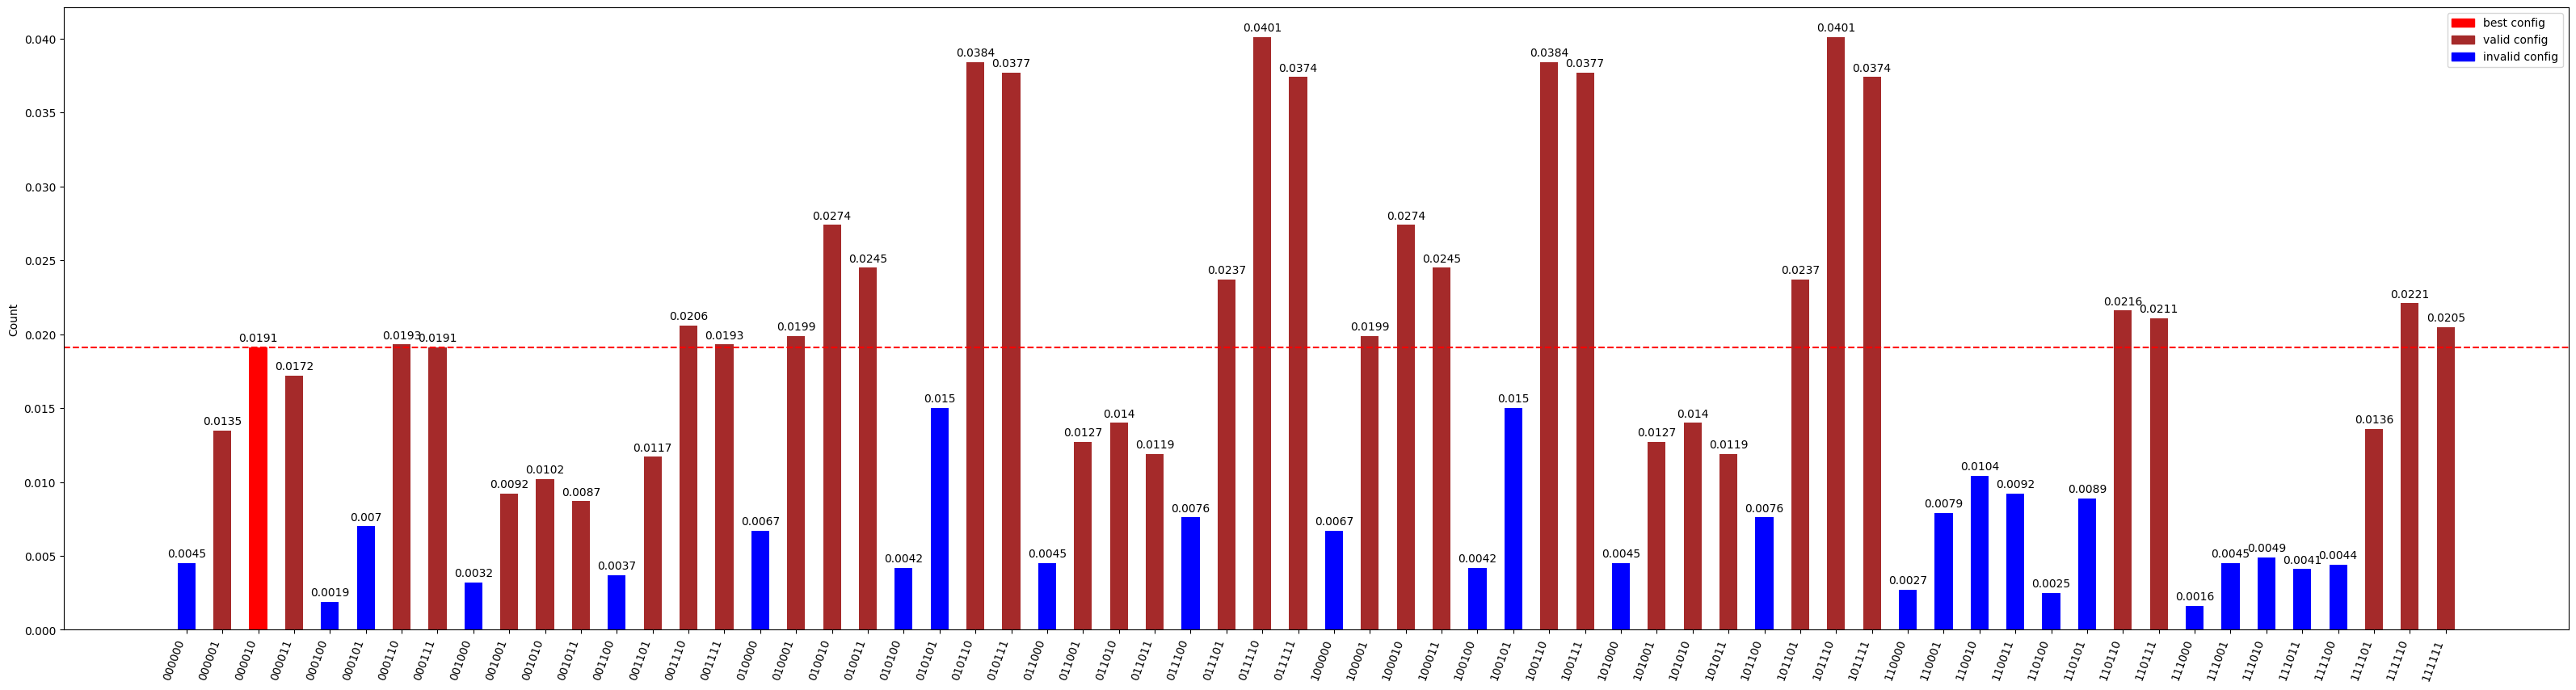

In [31]:
hamiltonian = combined_model.to_quso()

print("Quadratized Hamiltonian:")
pprint(hamiltonian)

probabilities, _ = apply_qaoa_statevector(qubo_problem_circuit, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=True)
probabilities_dict = {}
for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
    probabilities_dict[np.binary_repr(i, width=get_hamiltonian_dimension(hamiltonian))] = probabilities[i]

probabilities_dict = convert_ancilla_bit_results(probabilities_dict, n_features)

for key in probabilities_dict:
    probabilities_dict[key] = round(probabilities_dict[key], 4)

plot_counts_histogram(probabilities_dict, n_features, best_config, valid_configs)

## Configuration Prioritization using PUBO models

If we have an arbitrary SAT instance, we can use QAOA to find the most likely configuration. We can then exclude the configuration we found from the SAT instance by adding the following clause:

$$x_i \vee \dots \vee x_j \vee \neg x_k \vee \dots \vee \neg x_l$$

Where $x_i$ to $x_j$ are the variables that have the value $0$ for the found configuration and $x_k$ to $x_l$ are the variables that have the value $1$ for the found configuration.

We can then run QAOA again with this new SAT instance to find the next most likely configuration.
We can repeat this process until we have found a certain number of configurations, thus creating a prioritized list of configurations.

In [32]:
from qubovert import PCBO


def exclude_config(sat_instance: list[list[tuple[boolean_var, bool]]], boolean_vars: list[boolean_var], config: str)\
        -> list[list[tuple[boolean_var, bool]]]:
    """
        Excludes the given configuration from the given sat instance by adding a clause to the sat instance

        :param sat_instance: The sat instance to exclude the configuration from
        :param boolean_vars: The variables of the sat instance
        :param config: The configuration to exclude
    """
    sat_exclusion_clause = []
    for index, value in enumerate(config[::-1]):
        if value == '0':
            sat_exclusion_clause.append((boolean_vars[index], True))
        else:
            sat_exclusion_clause.append((boolean_vars[index], False))
    sat_instance.append(sat_exclusion_clause)
    return sat_instance


def convert_clause_to_penalty(clause: list[tuple[boolean_var, bool]]) -> tuple[PCBO, bool]:
    """
        Coverts a given clause of a SAT instance in conjunctive form to the corresponding penalty
        The clause is encoded as a list of tuples containing a boolean_var
        and False, if the variable is negated or True otherwise

        :param clause: the clause to convert
    """
    penalty = PCBO() + 1

    for var in clause:
        if var[1]:
            penalty *= (1 - var[0])
        else:
            penalty *= (var[0])
    return penalty, False


def convert_to_penalty(sat_instance: list[list[tuple[boolean_var, bool]]]) -> PCBO:
    """
        Converts a given SAT instance in conjunctive form to the corresponding penalty
        The SAT instance is encoded as a list of clauses.
        A clause is encoded as a list of tuples containing a boolean_var
        and False if the variable is negated or True otherwise

        :param sat_instance: the SAT instance to convert
    """
    penalty = PCBO()
    for clause in sat_instance:
        clause_penalty = convert_clause_to_penalty(clause)
        penalty += clause_penalty[0]
    return penalty

Current hamiltonian: {(0,): 35.0, (): 172.5, (1,): 65.0, (2,): -12.5, (4,): -30.0, (5,): -30.0, (0, 1): 50.0, (1, 2): -25.0, (2, 3): -25.0, (4, 5): 25.0, (1, 2, 3): -25.0, (1, 3): 25.0, (2, 4, 5): 25.0, (2, 5): -25.0, (2, 4): -25.0}


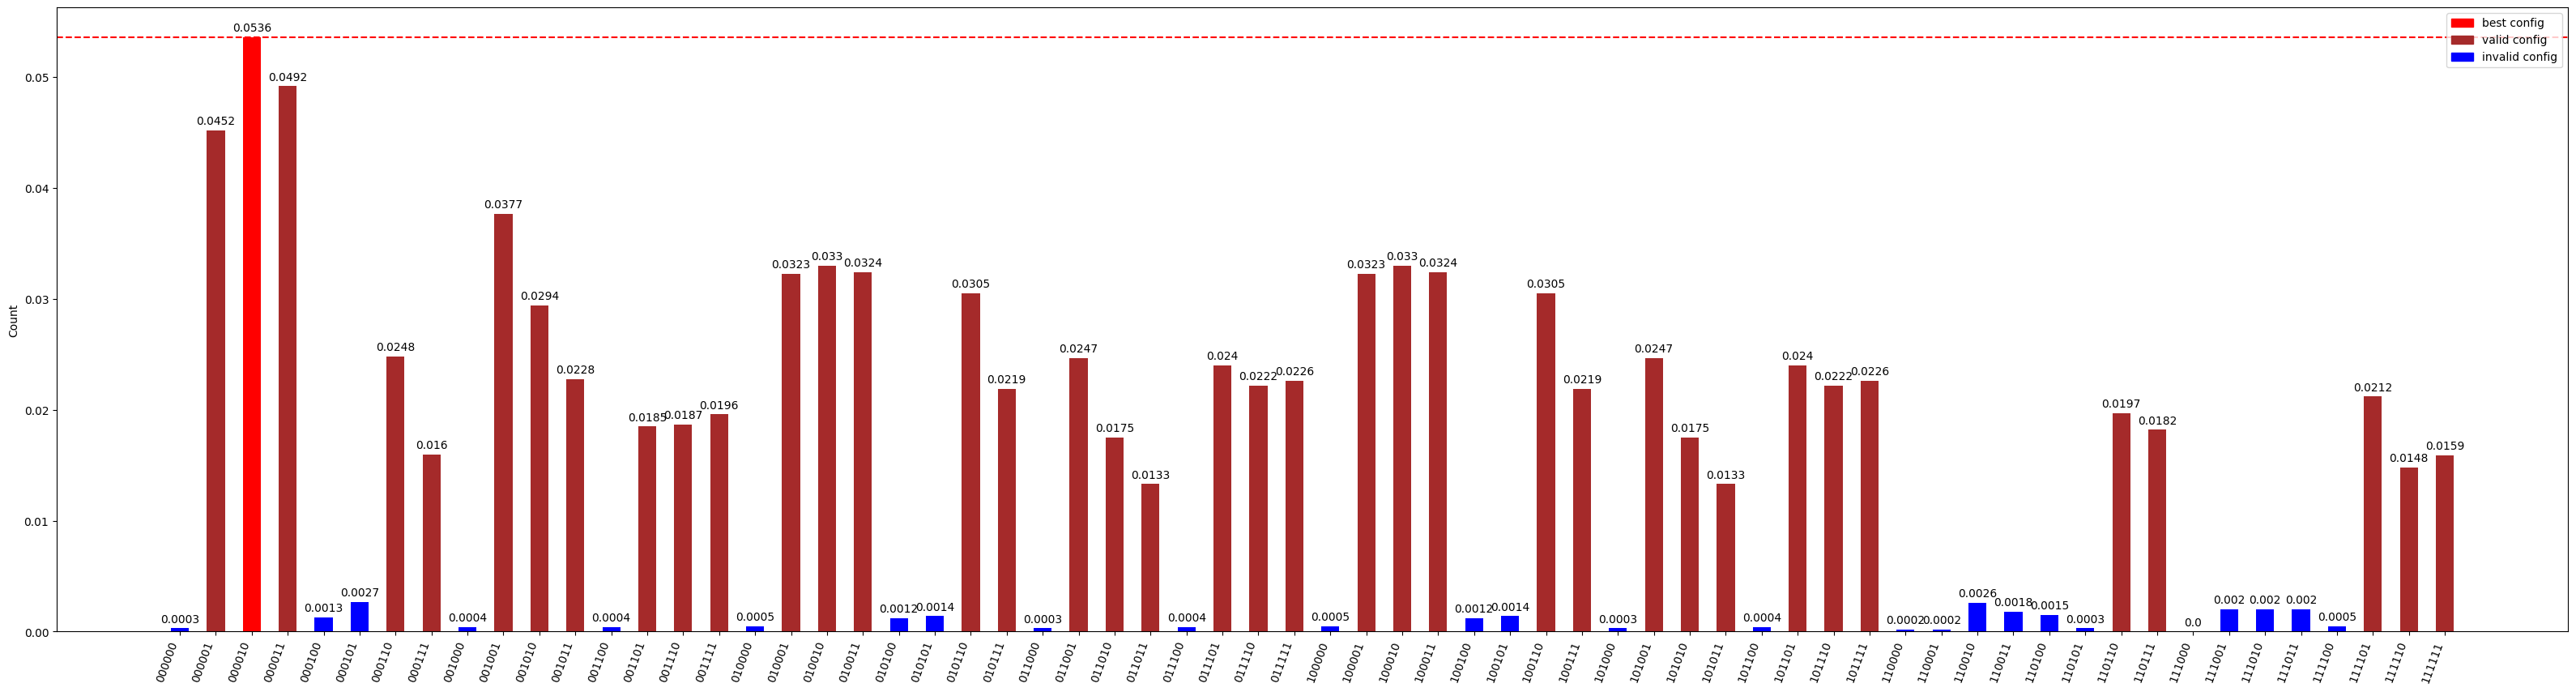

New combined model: {('x1',): -170, ('x2',): 20, ('x3',): 225, ('x4',): 50, ('x5',): 10, ('x6',): 10, (): 200, ('x2', 'x3', 'x4'): 400, ('x2', 'x3'): -400, ('x3', 'x4'): -200, ('x3', 'x5', 'x6'): -200, ('x5', 'x6'): 200, ('x1', 'x2', 'x3', 'x4', 'x5', 'x6'): -200, ('x1', 'x2', 'x3', 'x4', 'x5'): 200, ('x1', 'x2', 'x3', 'x4', 'x6'): 200, ('x1', 'x2', 'x3', 'x4'): -200, ('x1', 'x2', 'x3', 'x5', 'x6'): 200, ('x1', 'x2', 'x3', 'x5'): -200, ('x1', 'x2', 'x3', 'x6'): -200, ('x1', 'x2', 'x3'): 200, ('x1', 'x2', 'x4', 'x5', 'x6'): 200, ('x1', 'x2', 'x4', 'x5'): -200, ('x1', 'x2', 'x4', 'x6'): -200, ('x1', 'x2', 'x4'): 200, ('x1', 'x2', 'x5', 'x6'): -200, ('x1', 'x2', 'x5'): 200, ('x1', 'x2', 'x6'): 200, ('x2', 'x3', 'x4', 'x5', 'x6'): 200, ('x2', 'x3', 'x4', 'x5'): -200, ('x2', 'x3', 'x4', 'x6'): -200, ('x2', 'x3', 'x5', 'x6'): -200, ('x2', 'x3', 'x5'): 200, ('x2', 'x3', 'x6'): 200, ('x2', 'x4', 'x5', 'x6'): -200, ('x2', 'x4', 'x5'): 200, ('x2', 'x4', 'x6'): 200, ('x2', 'x4'): -200, ('x2', 'x5

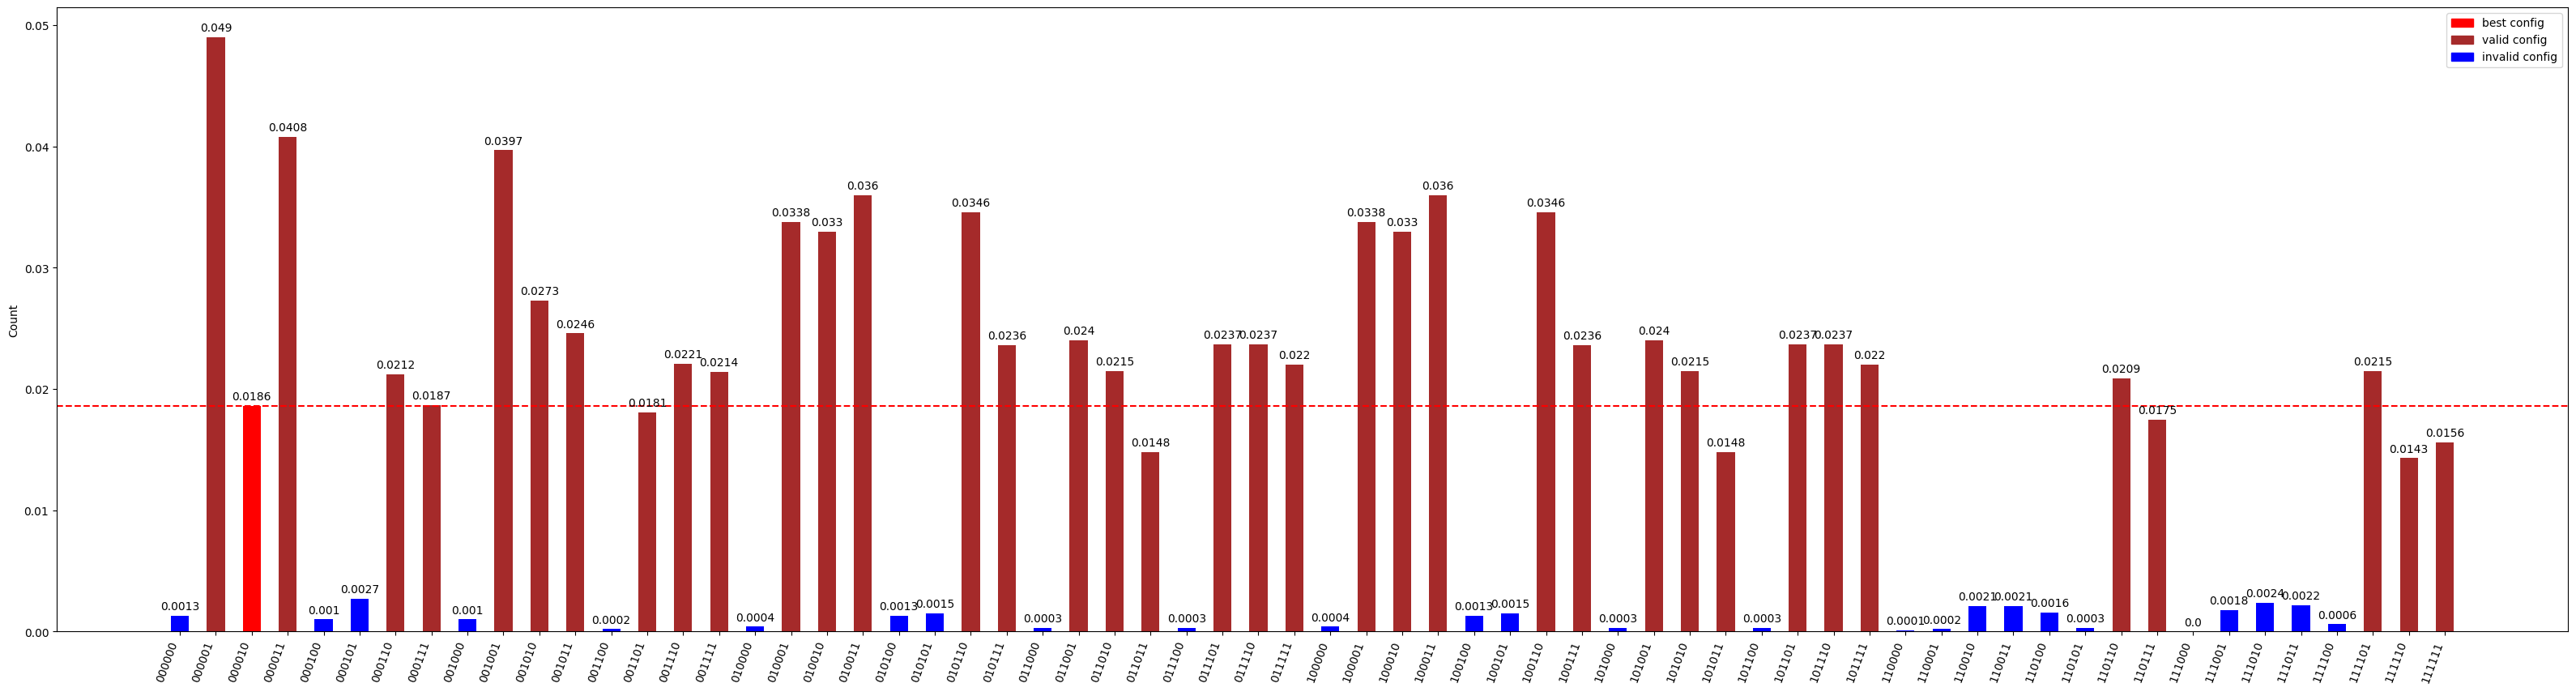

New combined model: {('x1',): 30, ('x2',): 20, ('x3',): 225, ('x4',): 50, ('x5',): 10, ('x6',): 10, (): 200, ('x2', 'x3', 'x4'): 400, ('x2', 'x3'): -400, ('x3', 'x4'): -200, ('x3', 'x5', 'x6'): -200, ('x5', 'x6'): 200, ('x1', 'x2', 'x3', 'x4', 'x5', 'x6'): -400, ('x1', 'x2', 'x3', 'x4', 'x5'): 400, ('x1', 'x2', 'x3', 'x4', 'x6'): 400, ('x1', 'x2', 'x3', 'x4'): -400, ('x1', 'x2', 'x3', 'x5', 'x6'): 400, ('x1', 'x2', 'x3', 'x5'): -400, ('x1', 'x2', 'x3', 'x6'): -400, ('x1', 'x2', 'x3'): 400, ('x1', 'x2', 'x4', 'x5', 'x6'): 400, ('x1', 'x2', 'x4', 'x5'): -400, ('x1', 'x2', 'x4', 'x6'): -400, ('x1', 'x2', 'x4'): 400, ('x1', 'x2', 'x5', 'x6'): -400, ('x1', 'x2', 'x5'): 400, ('x1', 'x2', 'x6'): 400, ('x2', 'x3', 'x4', 'x5', 'x6'): 200, ('x2', 'x3', 'x4', 'x5'): -200, ('x2', 'x3', 'x4', 'x6'): -200, ('x2', 'x3', 'x5', 'x6'): -200, ('x2', 'x3', 'x5'): 200, ('x2', 'x3', 'x6'): 200, ('x2', 'x4', 'x5', 'x6'): -200, ('x2', 'x4', 'x5'): 200, ('x2', 'x4', 'x6'): 200, ('x2', 'x4'): -200, ('x2', 'x5',

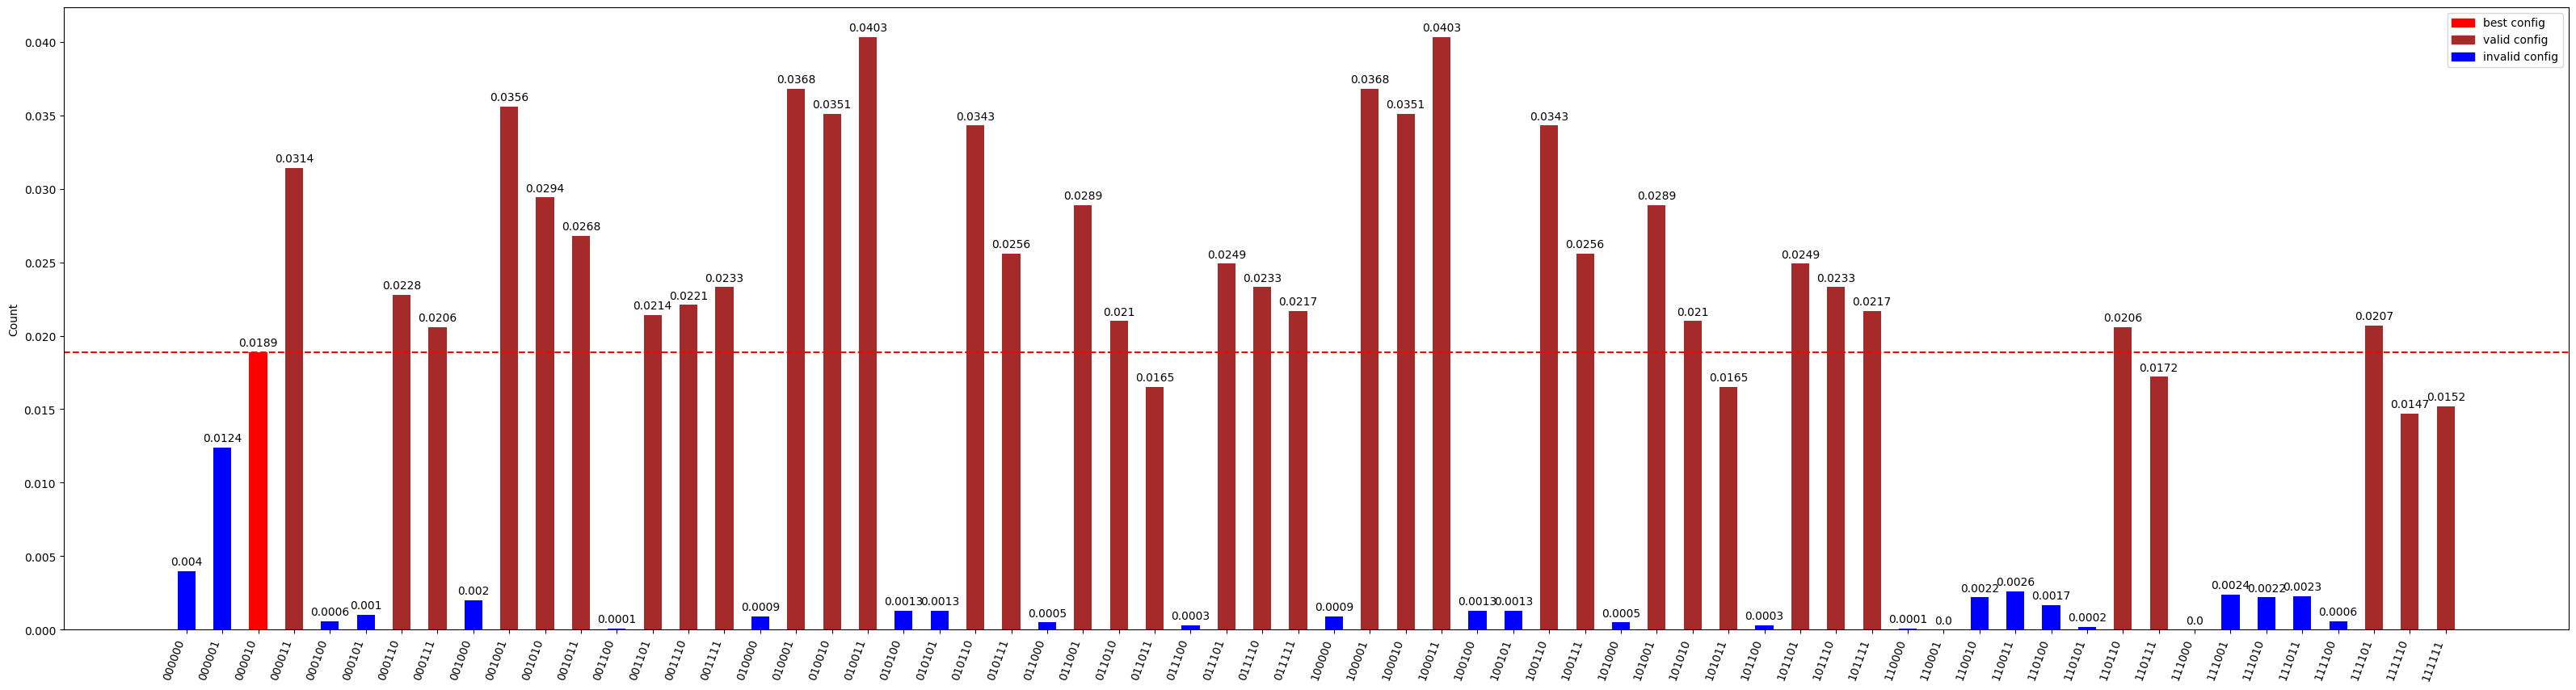

New combined model: {('x1',): 30, ('x2',): 20, ('x3',): 225, ('x4',): 50, ('x5',): 10, ('x6',): 10, (): 200, ('x2', 'x3', 'x4'): 400, ('x2', 'x3'): -400, ('x3', 'x4'): -200, ('x3', 'x5', 'x6'): -200, ('x5', 'x6'): 200, ('x1', 'x2', 'x3', 'x4', 'x5', 'x6'): -600, ('x1', 'x2', 'x3', 'x4', 'x5'): 600, ('x1', 'x2', 'x3', 'x4', 'x6'): 400, ('x1', 'x2', 'x3', 'x4'): -400, ('x1', 'x2', 'x3', 'x5', 'x6'): 600, ('x1', 'x2', 'x3', 'x5'): -600, ('x1', 'x2', 'x3', 'x6'): -400, ('x1', 'x2', 'x3'): 400, ('x1', 'x2', 'x4', 'x5', 'x6'): 600, ('x1', 'x2', 'x4', 'x5'): -600, ('x1', 'x2', 'x4', 'x6'): -400, ('x1', 'x2', 'x4'): 400, ('x1', 'x2', 'x5', 'x6'): -600, ('x1', 'x2', 'x5'): 600, ('x1', 'x2', 'x6'): 400, ('x2', 'x3', 'x4', 'x5', 'x6'): 200, ('x2', 'x3', 'x4', 'x5'): -200, ('x2', 'x3', 'x4', 'x6'): -200, ('x2', 'x3', 'x5', 'x6'): -200, ('x2', 'x3', 'x5'): 200, ('x2', 'x3', 'x6'): 200, ('x2', 'x4', 'x5', 'x6'): -200, ('x2', 'x4', 'x5'): 200, ('x2', 'x4', 'x6'): 200, ('x2', 'x4'): -200, ('x2', 'x5',

In [ ]:
list_length = 5
debug_output = True

current_sat_instance = [[(x1, True), (x2, True)],
                        [(x2, True), (x3, False), (x4, True)],
                        [(x3, True), (x5, False), (x6, False)]]
boolean_vars = [x1, x2, x3, x4, x5, x6]
prioritized_list = []
current_hamiltonian = combined_model.to_puso()
for i in range(list_length):
    probabilities, _ = apply_qaoa_statevector(problem_circuit, current_hamiltonian, strategy=strategy, print_res=False)
    probabilities_dict = {}
    for j in range(0, 2 ** get_hamiltonian_dimension(current_hamiltonian)):
        probabilities_dict[(np.binary_repr(j, width=get_hamiltonian_dimension(current_hamiltonian)))] = round(probabilities[j], 4)

    current_config = max(probabilities_dict, key=probabilities_dict.get)
    current_sat_instance = exclude_config(current_sat_instance, boolean_vars, current_config)
    new_combined_model = cost_model + alpha_sat * convert_to_penalty(current_sat_instance)

    if debug_output:
        print("Current hamiltonian: " + str(current_hamiltonian))
        plot_counts_histogram(probabilities_dict, get_hamiltonian_dimension(current_hamiltonian), best_config, valid_configs)
        print("New combined model: " + str(new_combined_model))

    valid_configs.remove(current_config)
    current_hamiltonian = new_combined_model.to_puso()
    prioritized_list.append(current_config)

print(prioritized_list)